# Lead Scoring Case Study 

- Supervised Learning Algorithm - Logistic Regression [ Classification ]
- Programming Language - Python
- Developed by UV, VK, VY


## Initialization - Preprocessing - Visualization

### 1. Package Imports and Data Initialization

In [45]:
# import all libraries numpy, pandas, matplotlib, seaborn. 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 900)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [46]:
# Import the necessary machine learning packages (sklearn, statsmodel) for performing logistic regression
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve

In [47]:
# Import the dataset from leads.csv
lead_score_df = pd.read_csv('Leads.csv')
lead_score_df.head(1)

Prospect ID  Lead Number Lead Origin Lead Source  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737         API  Olark Chat   

  Do Not Email Do Not Call  Converted  TotalVisits  \
0           No          No          0        0.000   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                 0.000  Page Visited on Website   

  Country Specialization How did you hear about X Education  \
0     NaN         Select                             Select   

  What is your current occupation  \
0                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   

                          Tags      Lead Quality  \
0  Interested in other courses  Low in Relevance   

  Update me on Supply Chain Content Get updates on DM Content Lead Profile  \
0                                No                        No       Select   

     City Asymmetrique Activity Index Asymmetrique Profile Index  \
0  Select                   02.Medium                  02.Medium   

   Asymmetrique Activity Score  Asymmetrique Profile Score  \
0                       15.000                      15.000   

  I agree to pay the amount through cheque  \
0                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified

###  ----------------------------------------------------------------------

### 2. Data Preprocesing - Part 1

#### Custom Functions for Preprocessing and EDA

In [48]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df, cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20):
            d_categories['int_cat'].append(col)
        else:
            if not isinstance(df[col][df[col].notna()].unique()[0], str):
                d_categories['float_ts'].append(col)
            else:
                d_categories['int_cat'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
 
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(12), labels=df[col].value_counts().head(12).index.str[:10], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False, )
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().head(15).index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:10], y=target, order=df[col].value_counts().index.str[:10], palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=90); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show();
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict(marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

#### Data Cleaning, Column Renaming, Missing Value Imputation, Feature Selection

In [49]:
#duplicates row validation by id cols
print(f"{lead_score_df.index.is_unique}, {lead_score_df.columns.is_unique}, {lead_score_df['Prospect ID'].is_unique}, {lead_score_df['Lead Number'].is_unique}")

True, True, True, True


In [50]:
# drop unnecessary columns
lead_score_df = lead_score_df.drop(columns=['Prospect ID', 'I agree to pay the amount through cheque', 'Last Notable Activity'])

In [51]:
# rename columns that are too long
lead_score_df = lead_score_df.rename(columns={'Total Time Spent on Website':'ttime_on_site', 'Page Views Per Visit':'pg_view_pv', 'How did you hear about X Education':'info_abt_X_Edu', 'What is your current occupation':'curr_occupation',
    'What matters most to you in choosing a course':'reason_behind_course', 'Receive More Updates About Our Courses':'more_course_updates', 'Update me on Supply Chain Content':'supply_chain_info', 'Get updates on DM Content':'get_dm',
    'Asymmetrique Activity Index':'asym_activ_idx', 'Asymmetrique Profile Index':'asym_prof_idx', 'Asymmetrique Activity Score':'asym_activ_score', 'Asymmetrique Profile Score':'asym_prof_score',
    'A free copy of Mastering The Interview':'avail_free_copy'})

In [52]:
# replace unnecessary space in columns with underscore and covert it to lower case
lead_score_df.columns = lead_score_df.columns.str.replace(pat=' ',repl='_', regex=True)
lead_score_df.columns = lead_score_df.columns.str.lower()

In [53]:
# Check the shape and size of the data frame
lead_score_df.head(1)
lead_score_df.dtypes
print(f'{lead_score_df.shape}, {lead_score_df.size}')

lead_number lead_origin lead_source do_not_email do_not_call  converted  \
0       660737         API  Olark Chat           No          No          0   

   totalvisits  ttime_on_site  pg_view_pv            last_activity country  \
0        0.000              0       0.000  Page Visited on Website     NaN   

  specialization info_abt_x_edu curr_occupation     reason_behind_course  \
0         Select         Select      Unemployed  Better Career Prospects   

  search magazine newspaper_article x_education_forums newspaper  \
0     No       No                No                 No        No   

  digital_advertisement through_recommendations more_course_updates  \
0                    No                      No                  No   

                          tags      lead_quality supply_chain_info get_dm  \
0  Interested in other courses  Low in Relevance                No     No   

  lead_profile    city asym_activ_idx asym_prof_idx  asym_activ_score  \
0       Select  Select      02.Medium     02.Medium            15.000   

   asym_prof_score avail_free_copy  
0           15.000              No

lead_number                  int64
lead_origin                 object
lead_source                 object
do_not_email                object
do_not_call                 object
converted                    int64
totalvisits                float64
ttime_on_site                int64
pg_view_pv                 float64
last_activity               object
country                     object
specialization              object
info_abt_x_edu              object
curr_occupation             object
reason_behind_course        object
search                      object
magazine                    object
newspaper_article           object
x_education_forums          object
newspaper                   object
digital_advertisement       object
through_recommendations     object
more_course_updates         object
tags                        object
lead_quality                object
supply_chain_info           object
get_dm                      object
lead_profile                object
city                

(9240, 34), 314160


In [54]:
# check null val percentage
# After checking the null value percentage for all the features
# We could see that there are many features that have more than 45% of non values

check_cols_null_pct(lead_score_df)

lead_quality              51.591
asym_prof_score           45.649
asym_activ_score          45.649
asym_prof_idx             45.649
asym_activ_idx            45.649
tags                      36.288
lead_profile              29.318
reason_behind_course      29.318
curr_occupation           29.113
country                   26.634
info_abt_x_edu            23.885
specialization            15.563
city                      15.368
pg_view_pv                 1.483
totalvisits                1.483
last_activity              1.115
lead_source                0.390
more_course_updates        0.000
get_dm                     0.000
supply_chain_info          0.000
lead_number                0.000
newspaper_article          0.000
through_recommendations    0.000
digital_advertisement      0.000
newspaper                  0.000
x_education_forums         0.000
lead_origin                0.000
magazine                   0.000
search                     0.000
ttime_on_site              0.000
converted 

In [55]:
# replace select string with nan
lead_score_df = lead_score_df.replace(to_replace=['select','Select'], value=np.nan)

# validate select str is replaced
[i for i in lead_score_df.columns if 'select' in (lead_score_df[i].astype(str).str.lower()).str.findall('select').value_counts().index.map(''.join).to_list()]

[]

##### Constant Feature Identification

In [56]:
# check constant features that has only one values
# In the given data set there are a lot of features that have only single value as a category
# These are called as constant features and these features are of little relevance for the machine learning model hence we dropped those features
 
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

constant_features = get_constant_features(lead_score_df)
constant_features.head(10)
"','".join(constant_features['Var'].to_list())

Desc                      Var Value    Perc
0        Constant                 magazine    No 100.000
1        Constant      more_course_updates    No 100.000
2        Constant        supply_chain_info    No 100.000
3        Constant                   get_dm    No 100.000
4  Quasi Constant       x_education_forums    No  99.989
5  Quasi Constant                newspaper    No  99.989
6  Quasi Constant              do_not_call    No  99.978
7  Quasi Constant        newspaper_article    No  99.978
8  Quasi Constant    digital_advertisement    No  99.957
9  Quasi Constant  through_recommendations    No  99.924

"magazine','more_course_updates','supply_chain_info','get_dm','x_education_forums','newspaper','do_not_call','newspaper_article','digital_advertisement','through_recommendations','search"

#####

In [57]:
# drop all the constant_features
lead_score_df = lead_score_df.drop(['magazine', 'more_course_updates', 'supply_chain_info', 'get_dm', 'x_education_forums', 
                                    'newspaper', 'do_not_call', 'newspaper_article', 'digital_advertisement', 'through_recommendations', 'search'], axis=1)

In [58]:
# convert dtypes
# Convert the data type of certain features from object to category type

obj_cols = lead_score_df.select_dtypes(include='object').columns
lead_score_df[obj_cols] = lead_score_df[obj_cols].astype(dtype='category')

In [59]:
# check null val percentage
# Since we have replaced select as null value for certain columns we are seeing increase in the null value percentage for those features
# Therefore we dropped all the features that have more than 40 of null values

null_pct = check_cols_null_pct(lead_score_df)
null_pct
lead_score_df = lead_score_df.drop(null_pct[null_pct > 40].index, axis=1)

info_abt_x_edu         78.463
lead_profile           74.188
lead_quality           51.591
asym_prof_score        45.649
asym_activ_score       45.649
asym_prof_idx          45.649
asym_activ_idx         45.649
city                   39.708
specialization         36.580
tags                   36.288
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
totalvisits             1.483
pg_view_pv              1.483
last_activity           1.115
lead_source             0.390
lead_number             0.000
lead_origin             0.000
ttime_on_site           0.000
converted               0.000
do_not_email            0.000
avail_free_copy         0.000
dtype: float64

In [60]:
null_pct = check_cols_null_pct(lead_score_df)
null_pct
na_cols = null_pct[null_pct > 0].index
na_cols

city                   39.708
specialization         36.580
tags                   36.288
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
totalvisits             1.483
pg_view_pv              1.483
last_activity           1.115
lead_source             0.390
lead_number             0.000
lead_origin             0.000
do_not_email            0.000
converted               0.000
ttime_on_site           0.000
avail_free_copy         0.000
dtype: float64

Index(['city', 'specialization', 'tags', 'reason_behind_course',
       'curr_occupation', 'country', 'totalvisits', 'pg_view_pv',
       'last_activity', 'lead_source'],
      dtype='object')

In [61]:
lead_score_df.describe(include=np.number)
lead_score_df.describe(exclude=np.number)

lead_number  converted  totalvisits  ttime_on_site  pg_view_pv
count     9240.000   9240.000     9103.000       9240.000    9103.000
mean    617188.436      0.385        3.445        487.698       2.363
std      23405.996      0.487        4.855        548.021       2.161
min     579533.000      0.000        0.000          0.000       0.000
25%     596484.500      0.000        1.000         12.000       1.000
50%     615479.000      0.000        3.000        248.000       2.000
75%     637387.250      1.000        5.000        936.000       3.000
max     660737.000      1.000      251.000       2272.000      55.000

lead_origin lead_source do_not_email last_activity  \
count                      9240        9204         9240          9137   
unique                        5          21            2            17   
top     Landing Page Submission      Google           No  Email Opened   
freq                       4886        2868         8506          3437   

       country      specialization curr_occupation     reason_behind_course  \
count     6779                5860            6550                     6531   
unique      38                  18               6                        3   
top      India  Finance Management      Unemployed  Better Career Prospects   
freq      6492                 976            5600                     6528   

                                       tags    city avail_free_copy  
count                                  5887    5571            9240  
unique                                   26       6               2  
top     Will revert after reading the email  Mumbai              No  
freq                                   2072    3222            6352

In [62]:
# impute missing categorical values using mode, if a particular value in that column has higher frequency say > 50%
for i in lead_score_df.select_dtypes(include='category'):
    temp = lead_score_df[i].value_counts(normalize=True, ascending=False) * 100
    if temp.iloc[0] > 50:
        lead_score_df[i] = lead_score_df[i].fillna(temp.index[0])

In [63]:
# Now there are only two columns that have more than 36 off missing values tags and specialization

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

specialization   36.580
tags             36.288
totalvisits       1.483
pg_view_pv        1.483
last_activity     1.115
lead_source       0.390
dtype: float64

In [64]:
lead_score_df.dtypes

lead_number                int64
lead_origin             category
lead_source             category
do_not_email            category
converted                  int64
totalvisits              float64
ttime_on_site              int64
pg_view_pv               float64
last_activity           category
country                 category
specialization          category
curr_occupation         category
reason_behind_course    category
tags                    category
city                    category
avail_free_copy         category
dtype: object

###  ----------------------------------------------------------------------

### 3. Data Visualization - EDA

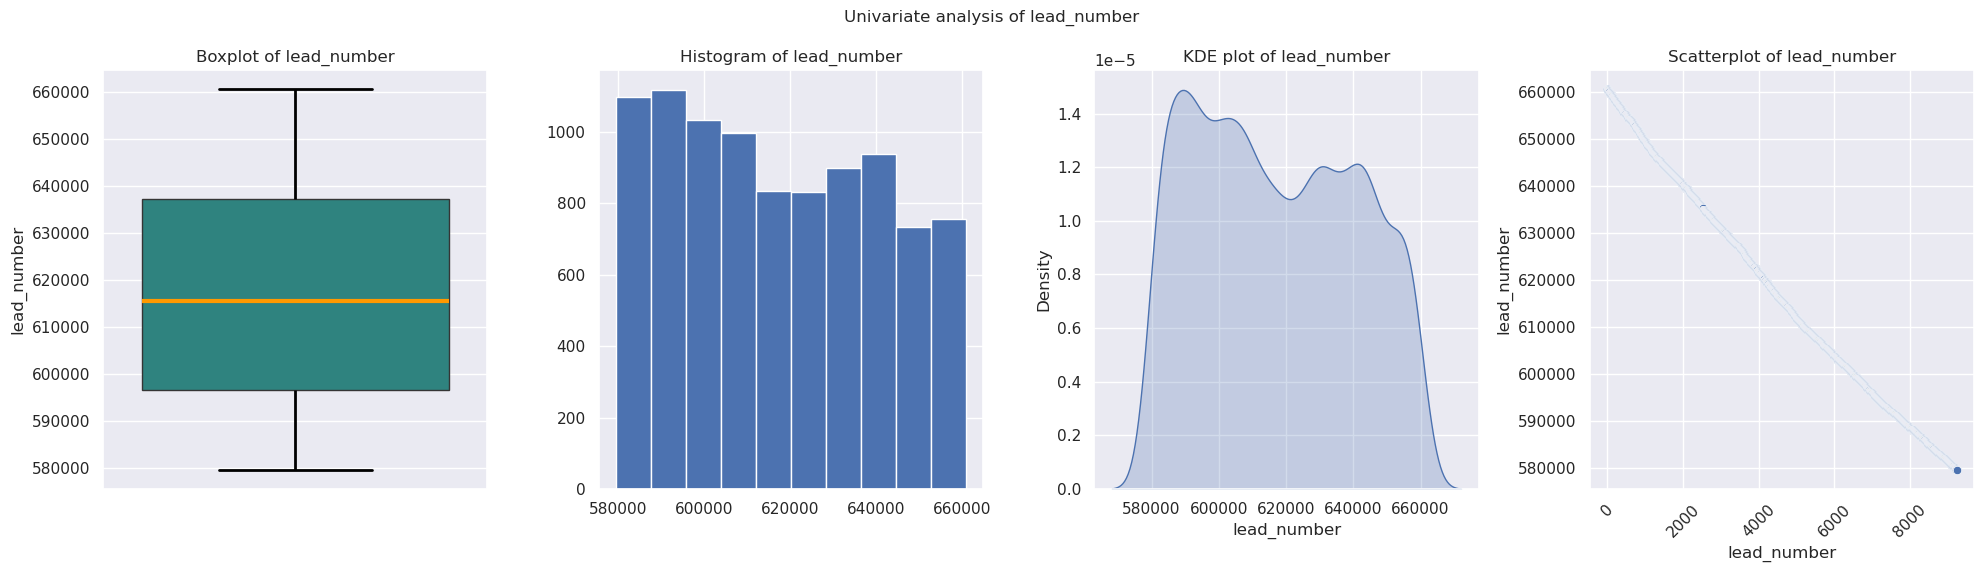

<Figure size 640x480 with 0 Axes>

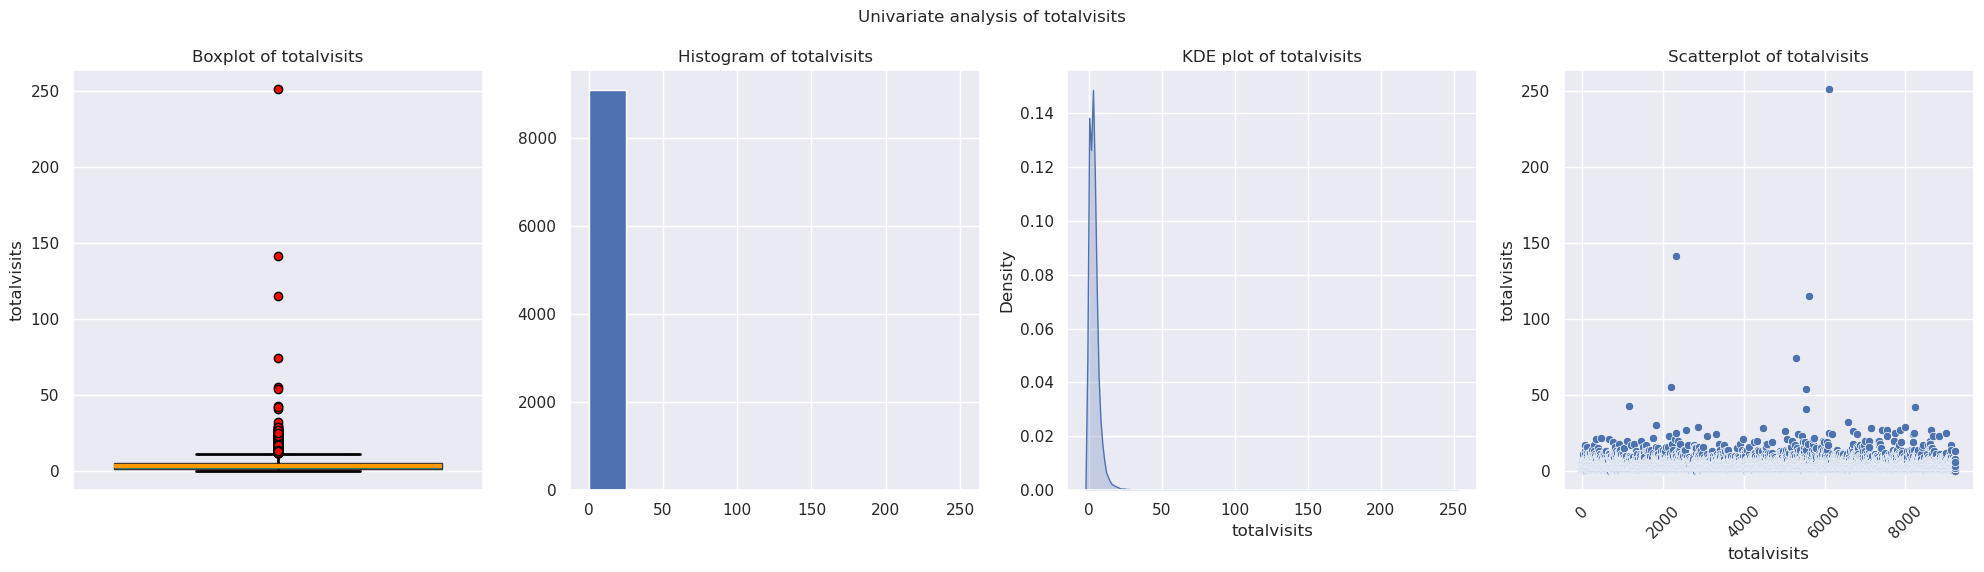

<Figure size 640x480 with 0 Axes>

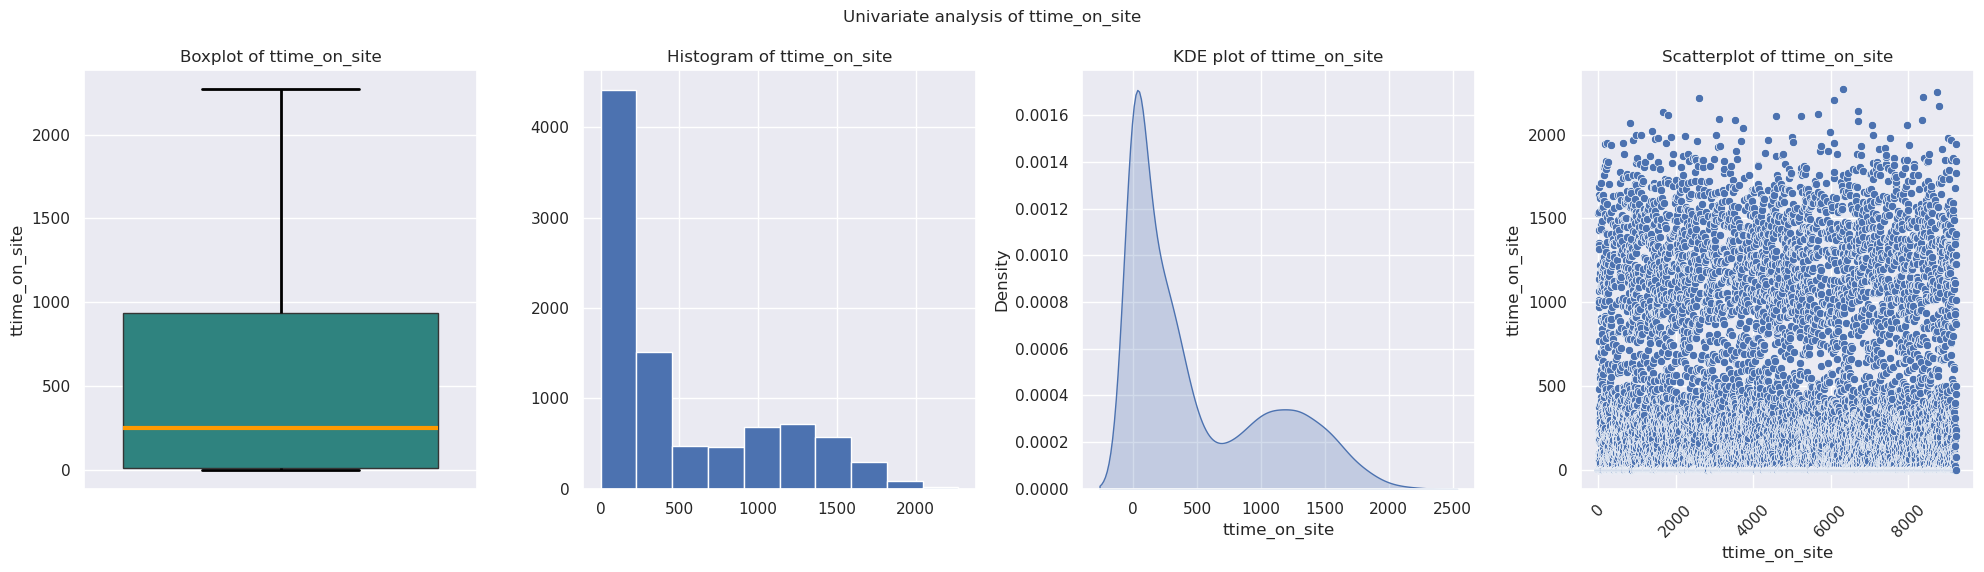

<Figure size 640x480 with 0 Axes>

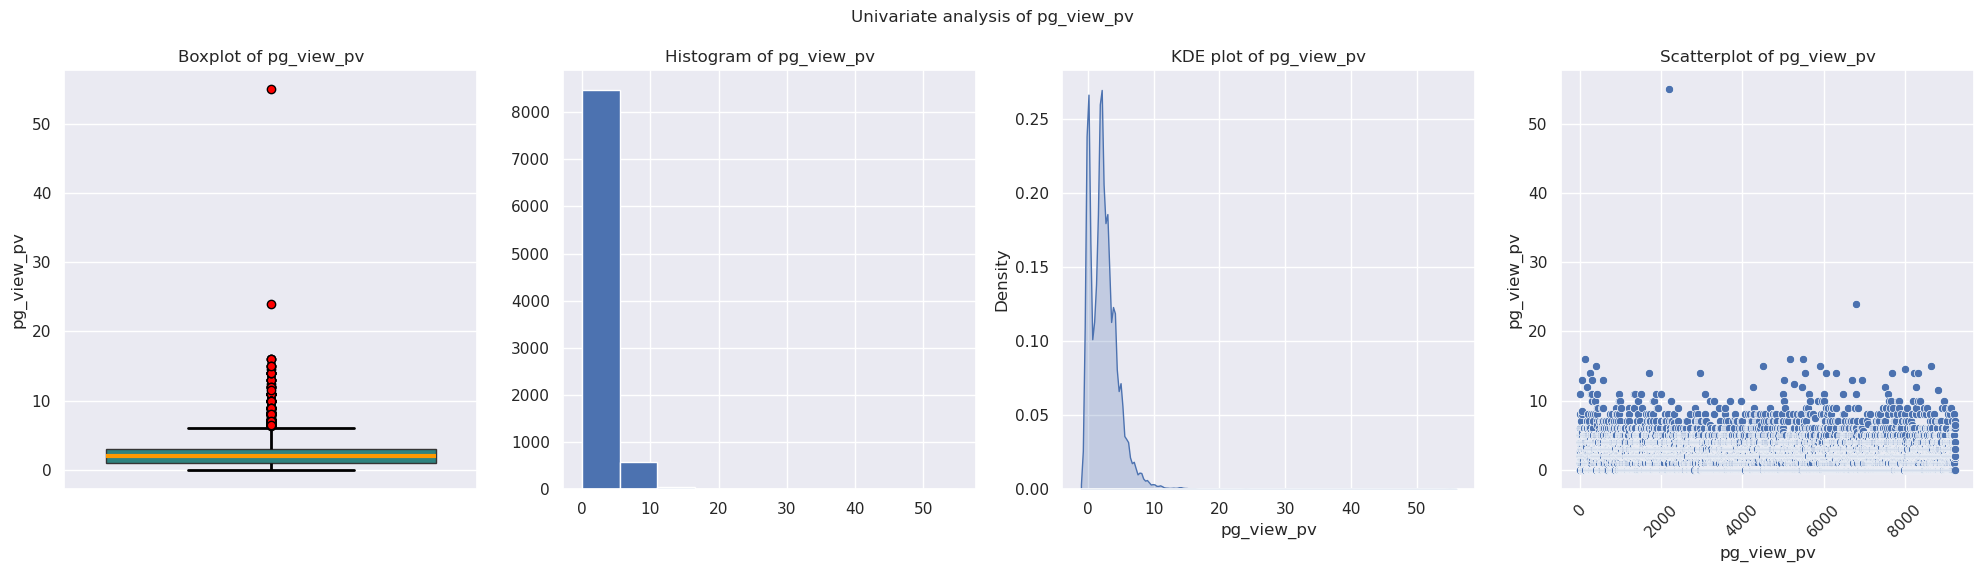

<Figure size 640x480 with 0 Axes>

In [65]:
# univariate plots#
# Now we perform Univariate analysis on both categorical and numerical variables
dtype_dict = classify_feature_dtype(lead_score_df, lead_score_df.columns )
univariate_plots(lead_score_df, dtype_dict['float_ts'], ftype='non_categorical', target='converted')

#####  Observations

- The converter column has more ones than zeros
- The box plot for total visits shows that there are outliers and the majority of the total visits fall between zero and 30
- The box plot for page view per visit shows that there are outliers majority of them fall between zero and 20

#####

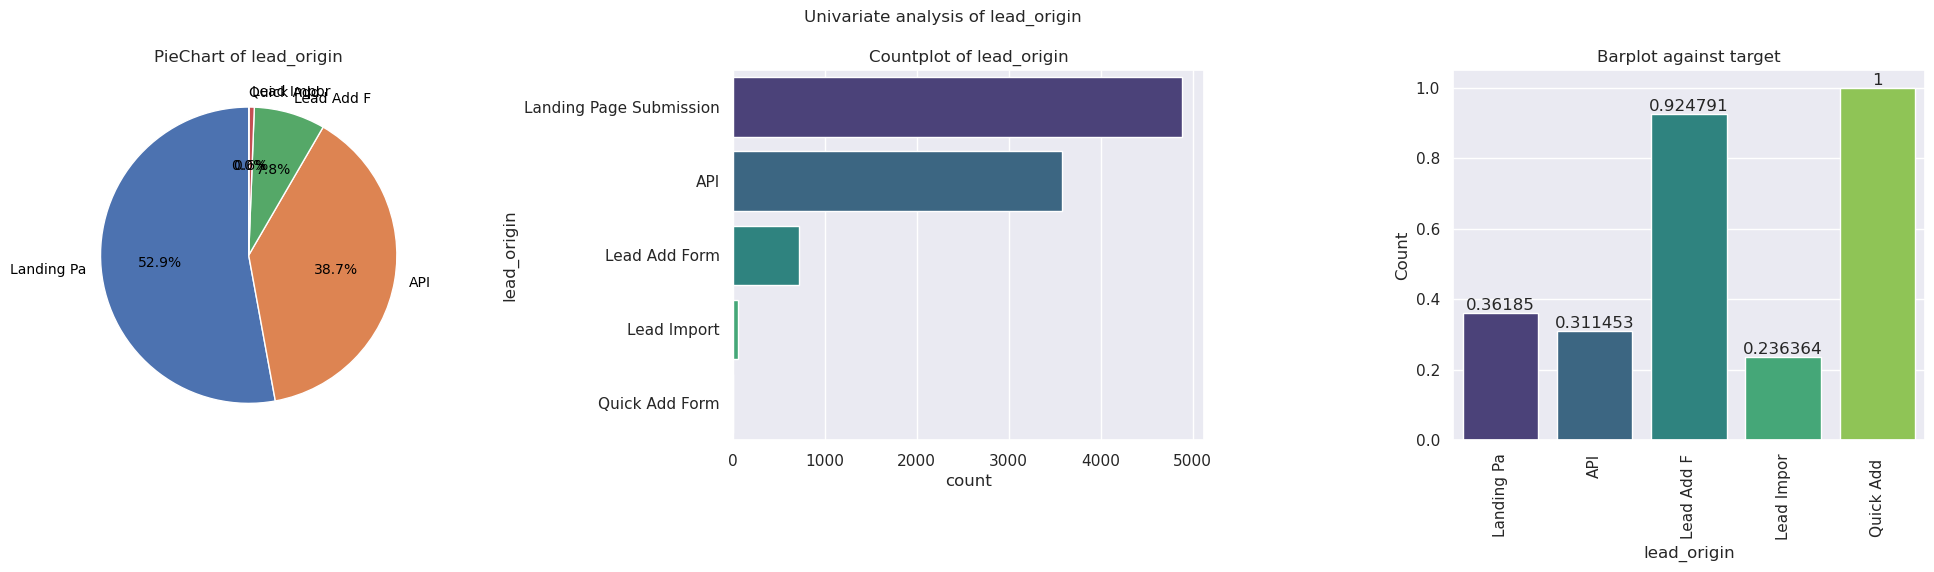

<Figure size 640x480 with 0 Axes>

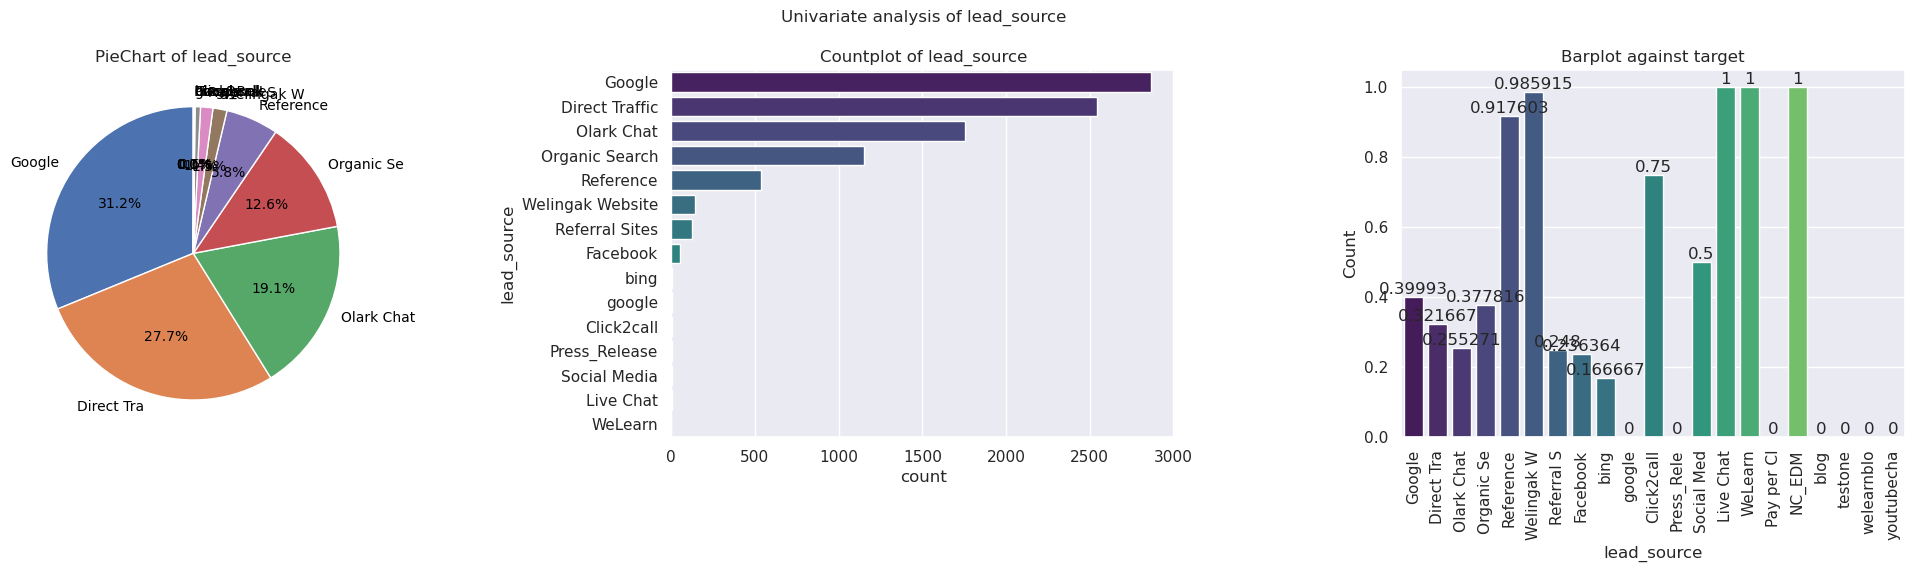

<Figure size 640x480 with 0 Axes>

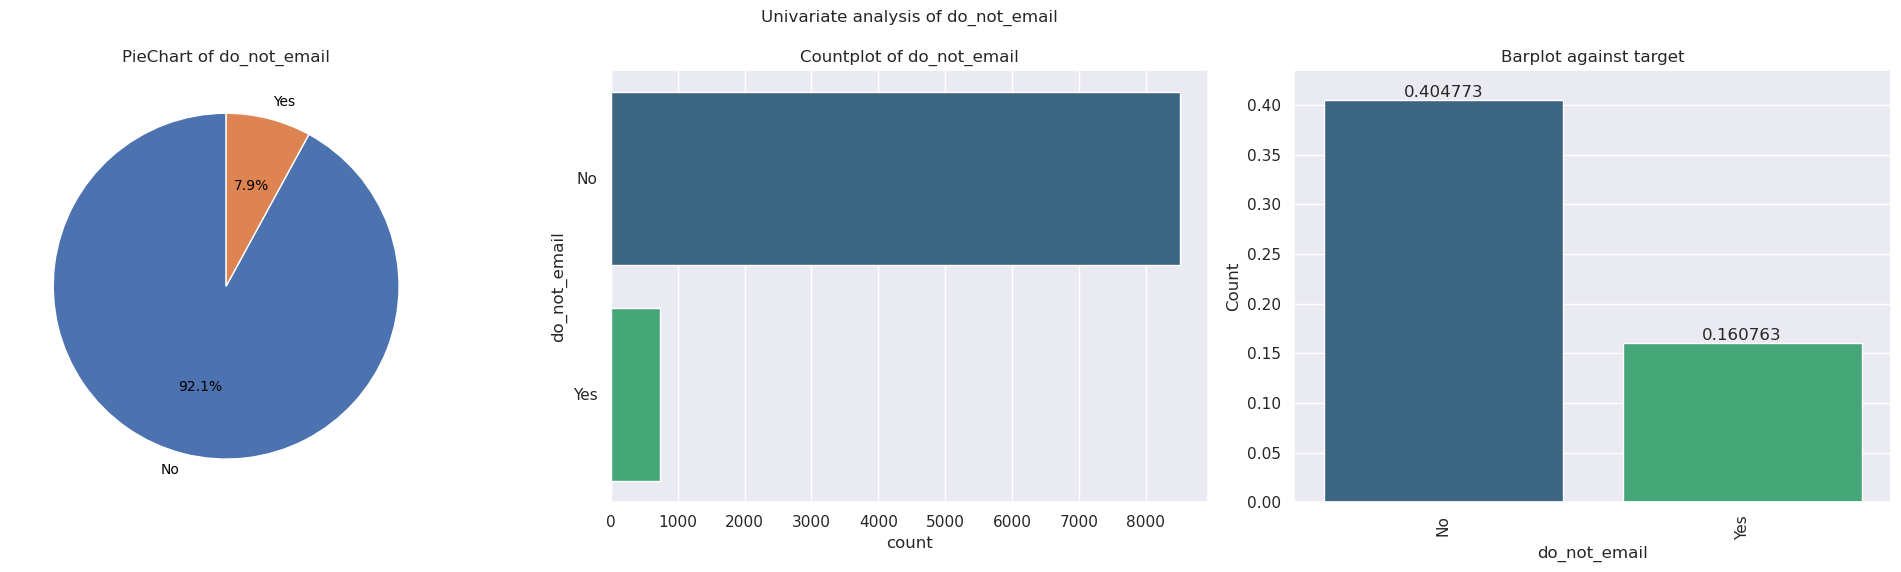

<Figure size 640x480 with 0 Axes>

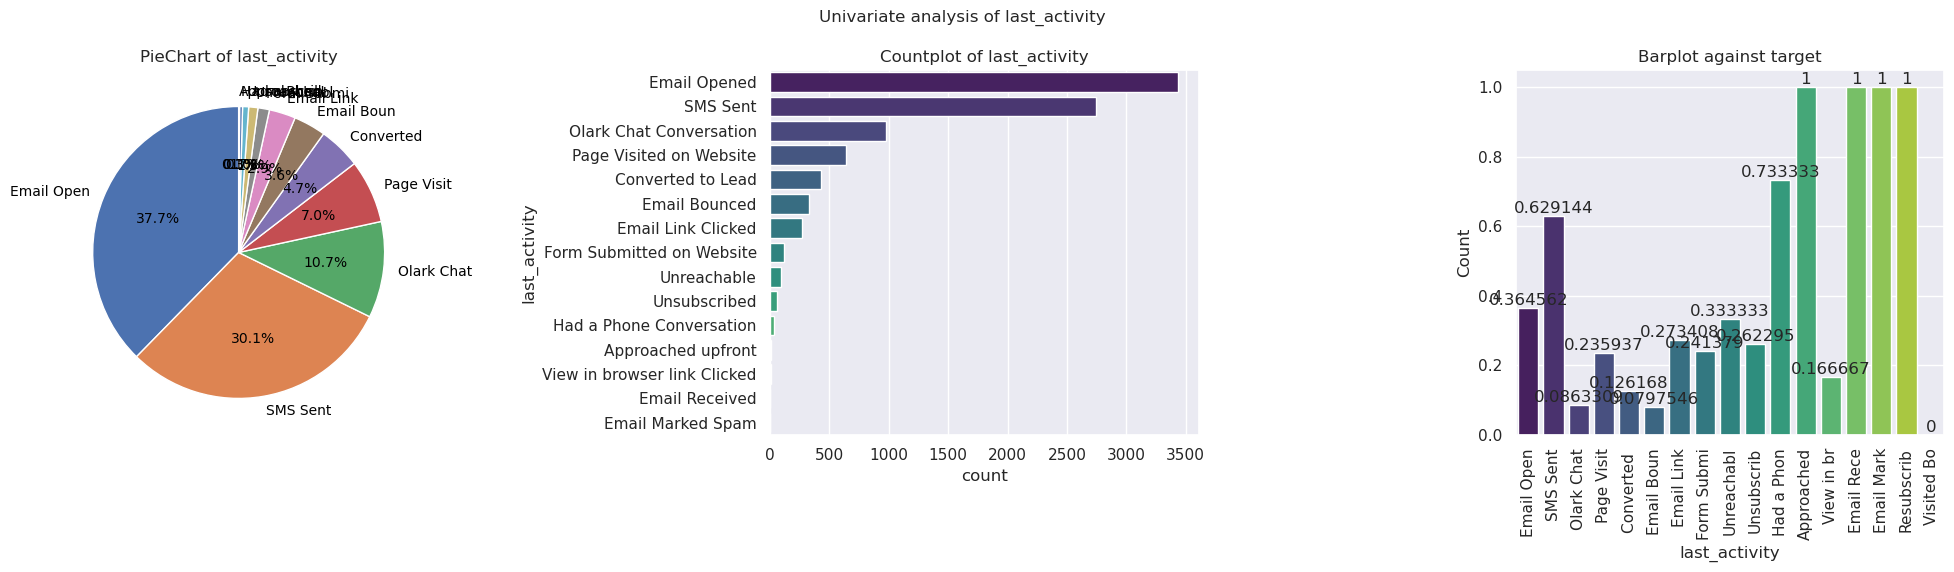

<Figure size 640x480 with 0 Axes>

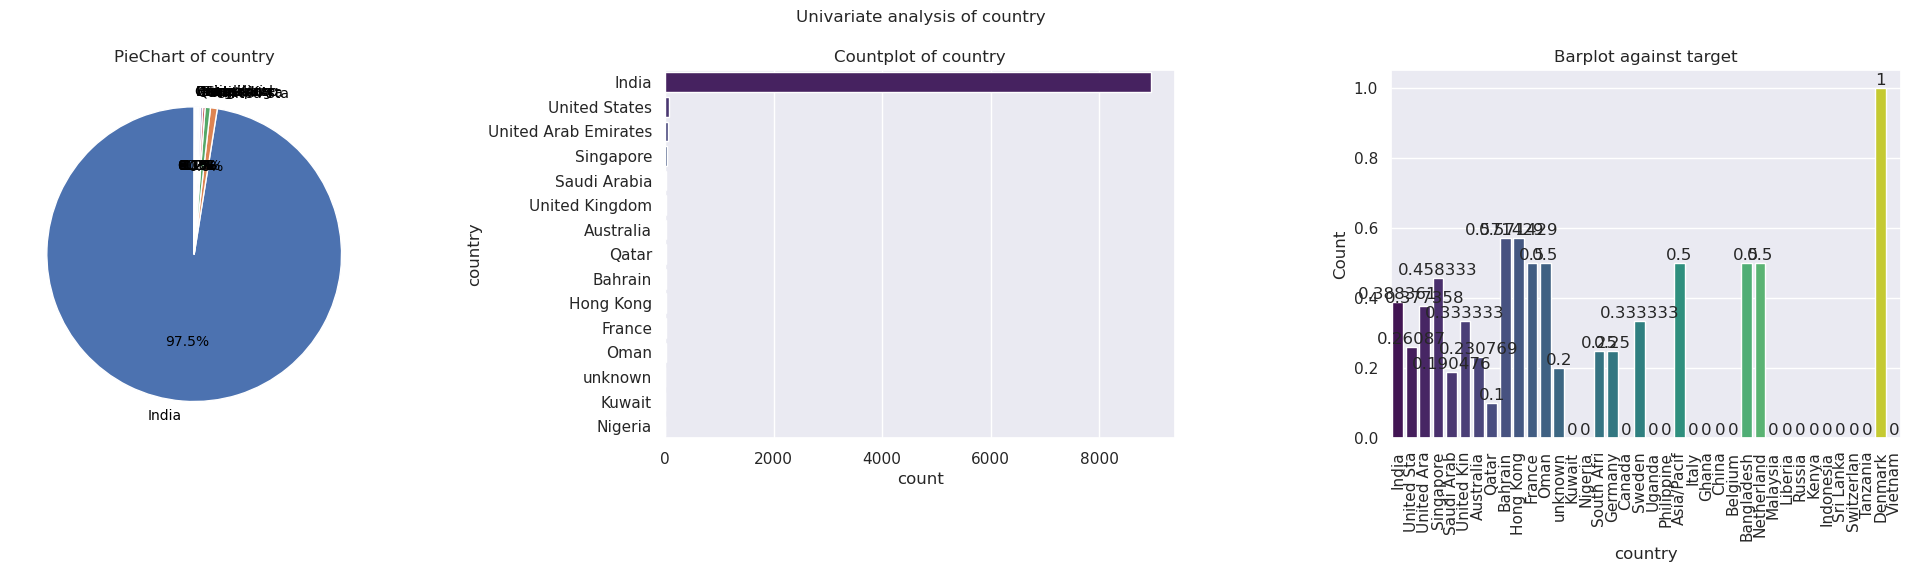

<Figure size 640x480 with 0 Axes>

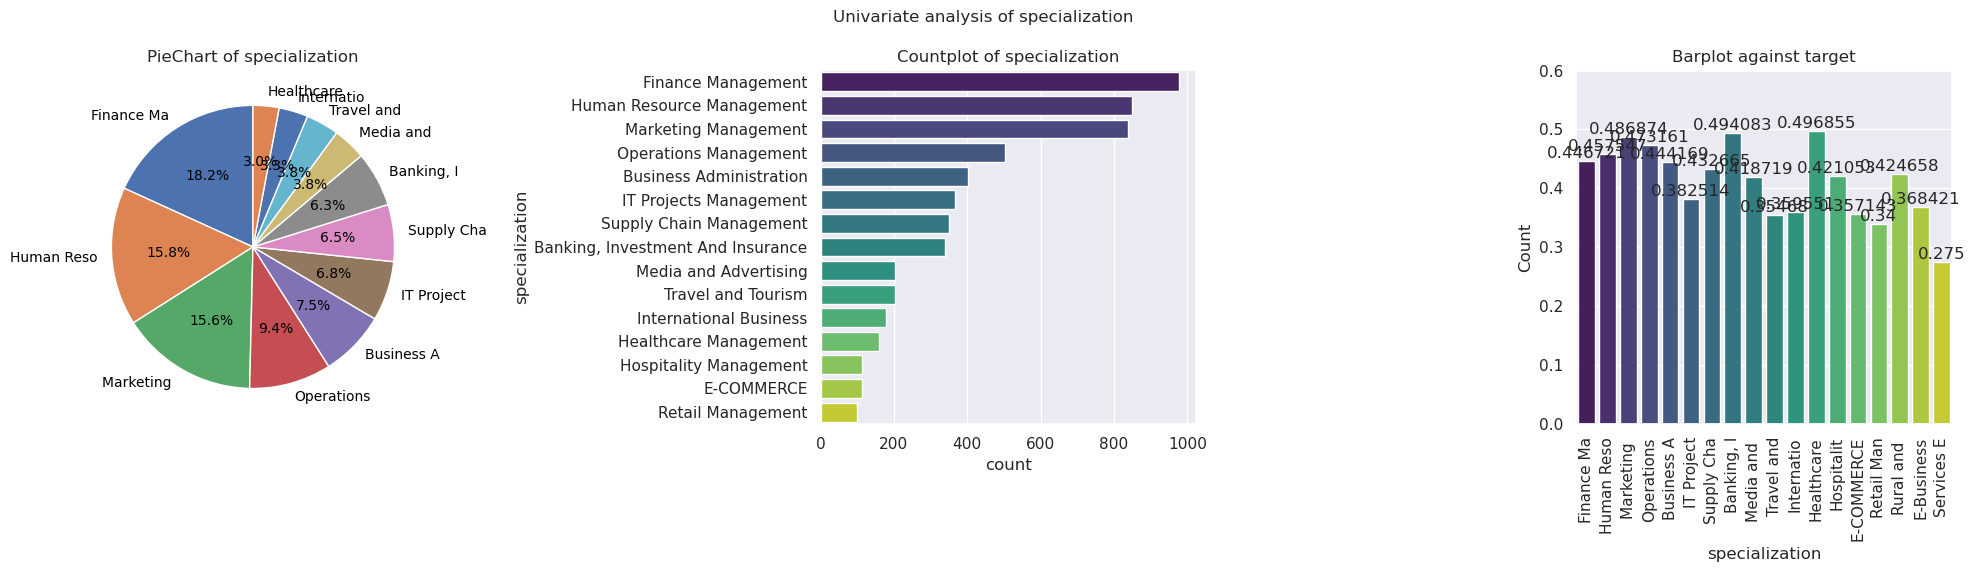

<Figure size 640x480 with 0 Axes>

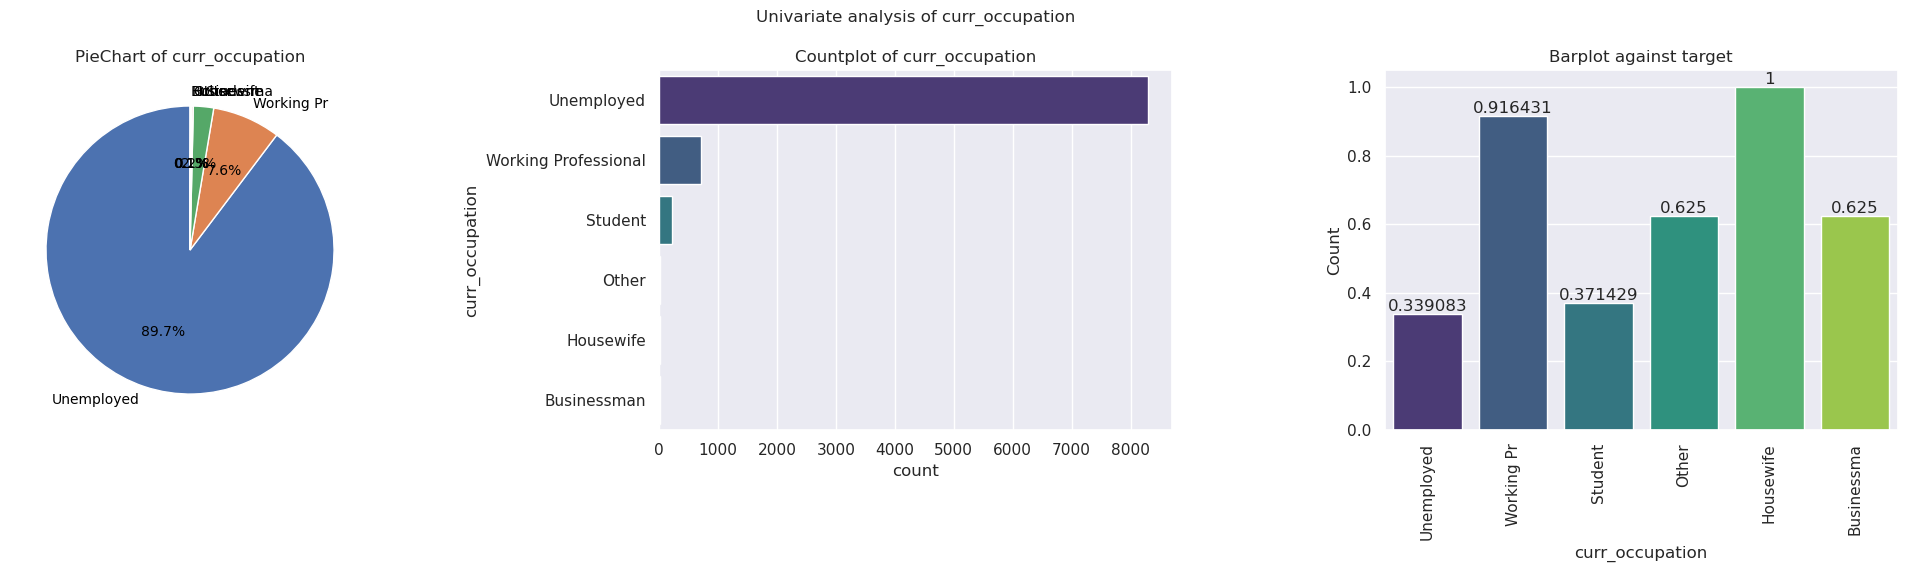

<Figure size 640x480 with 0 Axes>

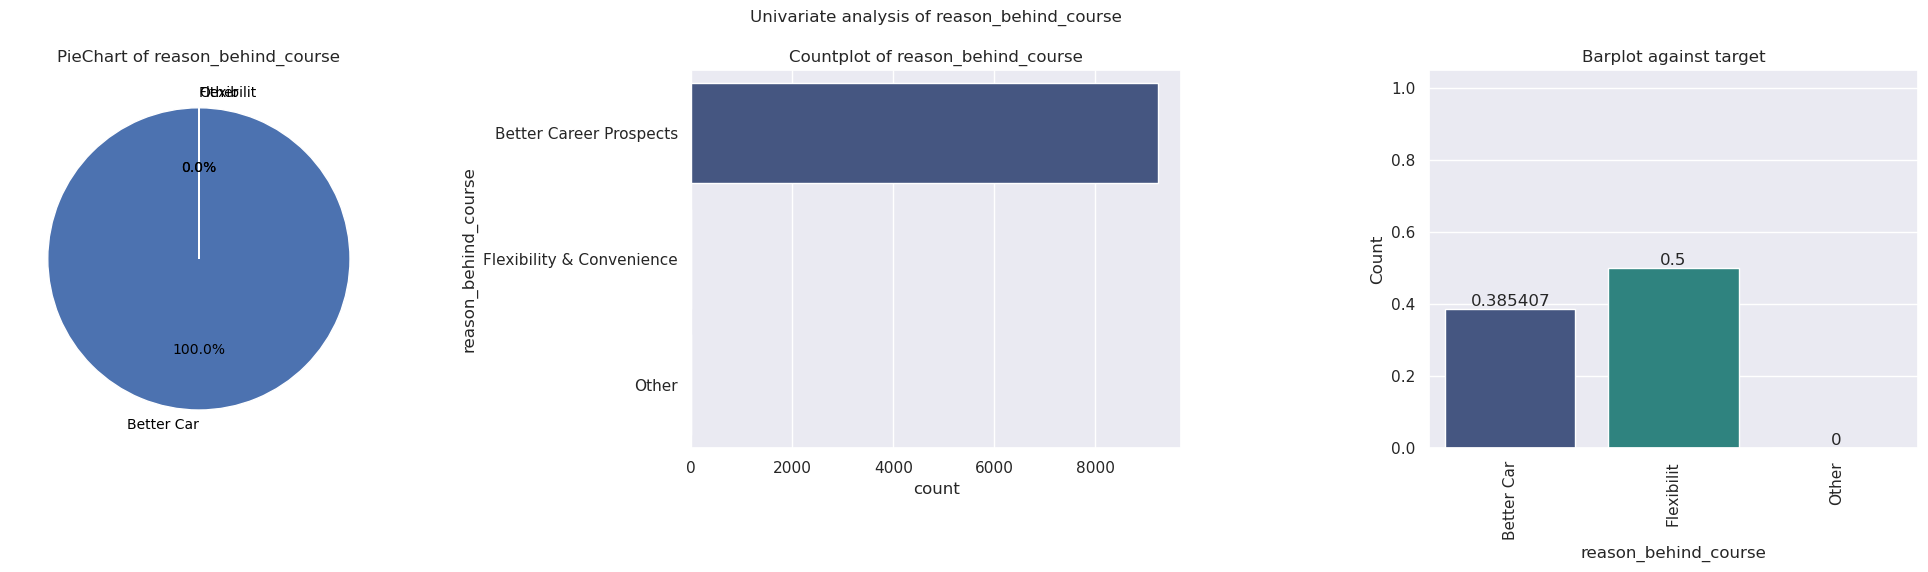

<Figure size 640x480 with 0 Axes>

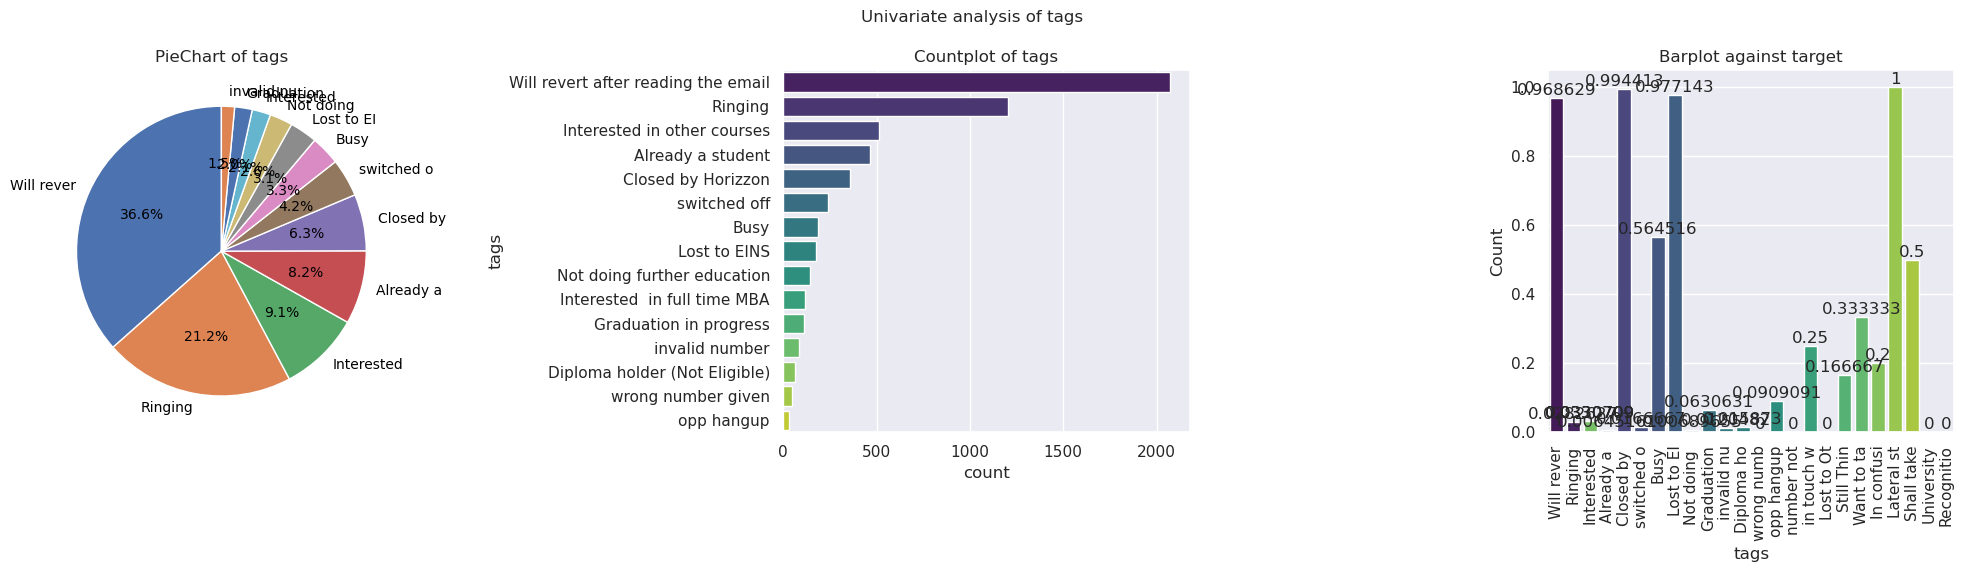

<Figure size 640x480 with 0 Axes>

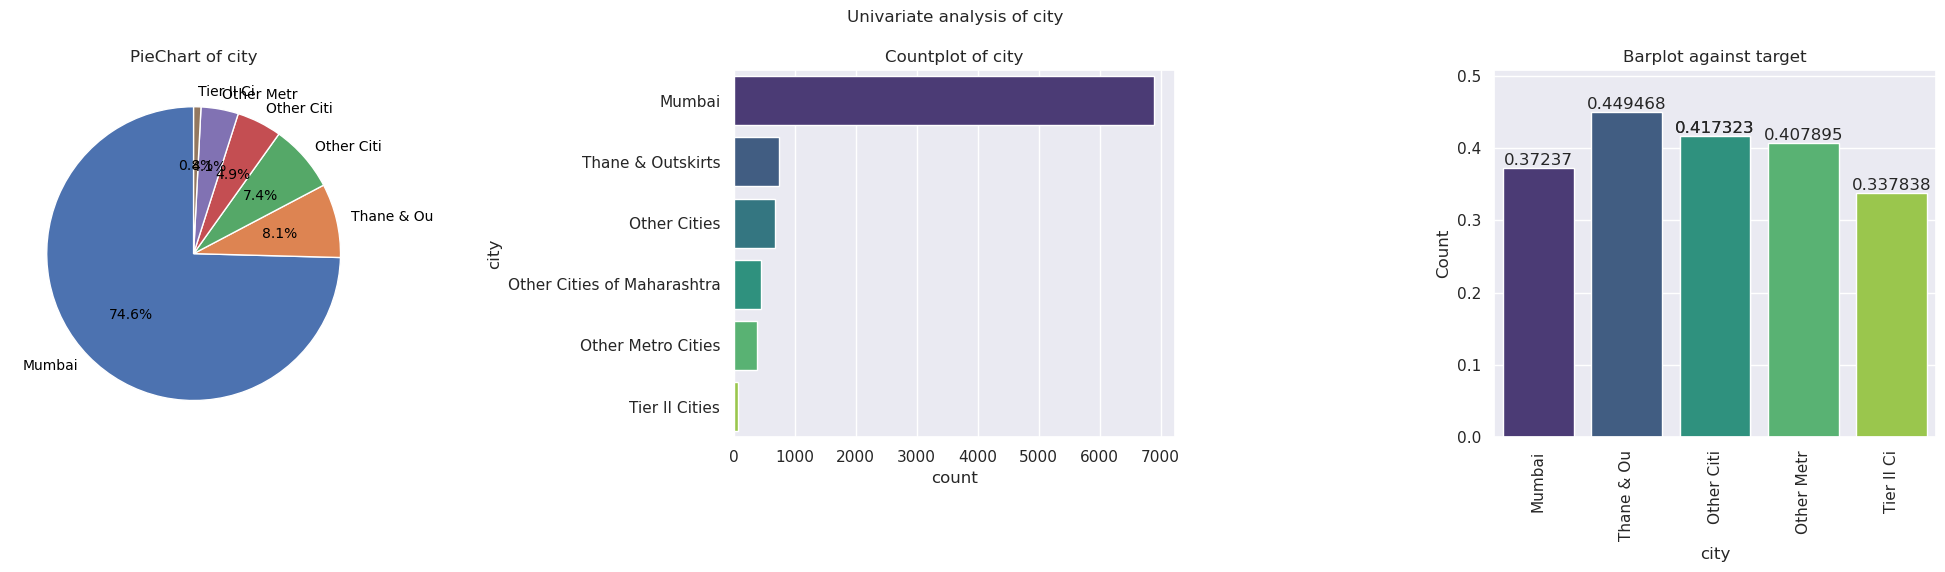

<Figure size 640x480 with 0 Axes>

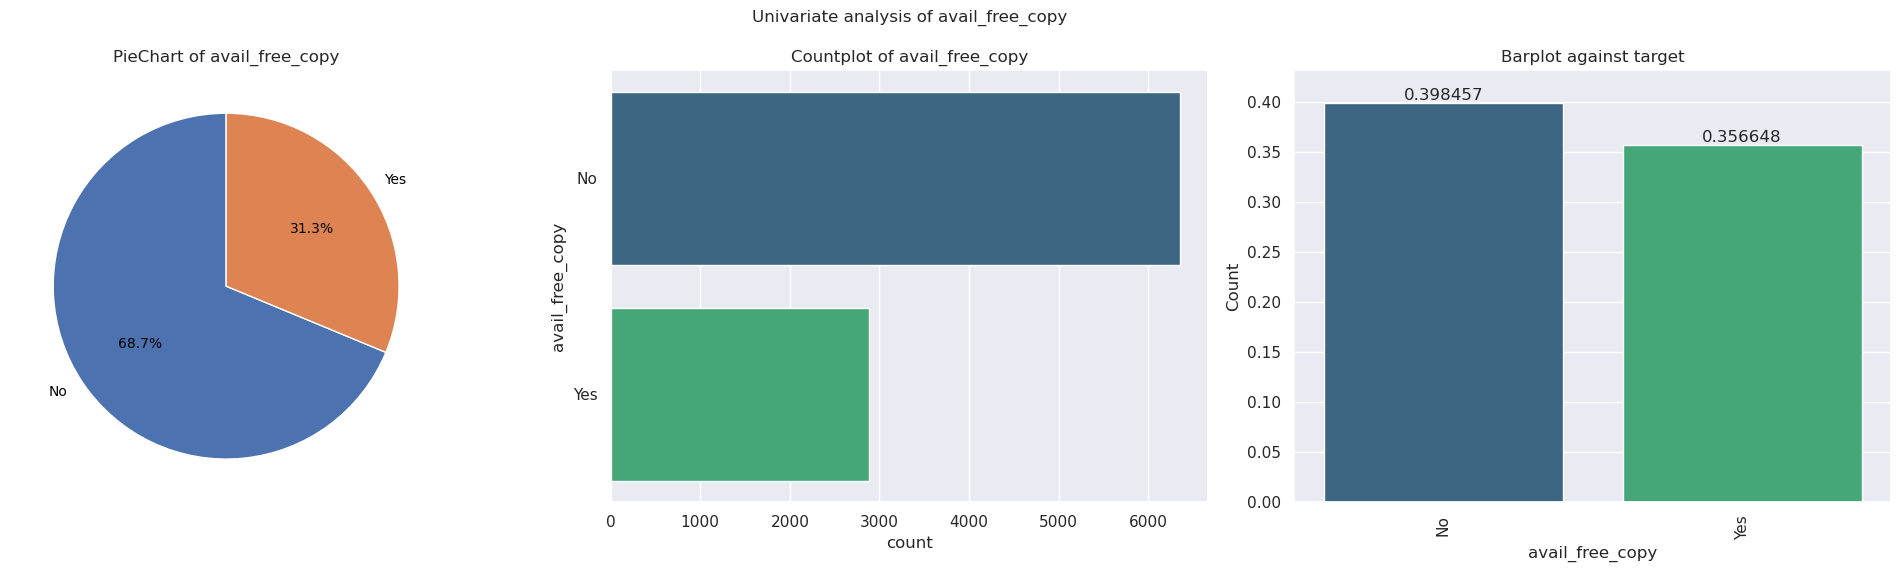

<Figure size 640x480 with 0 Axes>

In [66]:
# univariate plots
cols = dtype_dict['int_cat'].copy()
cols.remove('converted')
univariate_plots(lead_score_df, cols, ftype='categorical', target='converted')

####  Observations

##### The categorical analysis
 - More than 50 per cent of the users are by originated landing page following which the apis have 38 of leeds
 - When it comes to lead origin conversion rates lead add form has higher conversion rates holistically all have similar probability rate
 
 - When it comes to lead source 30 are from google twenty seven percent are from direct traffic 19 are from olak chat
 
 - For the do not email feature 90 of them chose no while 7 of them chose yes therefore majority of them are interested in the edtech platform
 - Also the people who have said no also the users who said no have a higher percent of conversion rate
  
 - The last activity of majority of the users say 38 of users are email opened followed by sms sent therefore we can say that
 - Majority of the users are active on email conversations
  
 - Majority of the users are from india
 - We can we can assume that air tech has a higher popularity in india or higher interest in india higher demand in india
 
 - Among the employed users most of the interested users have finance management as a specialization followed by human resource management and marketing management almost all specialization has a similar conversion rate
 
 - Majority of the users are unemployed followed by working professionals
 - Working professionals have a higher conversion rates while the user count is low in comparison to unemployed
  
 - Majority of the users have chosen better career prospects as a reason for opting for the course
 
 - The majority of the leads have been tagged under will revert after reading the email
 
 - Maximum number of leads have been from the city of mumbai followed by thane almost all categories have similar probabilities of conversion
  
 - 90 of the leads have opted not to free copy of the interview while 31 are opted for interview copy
 

####

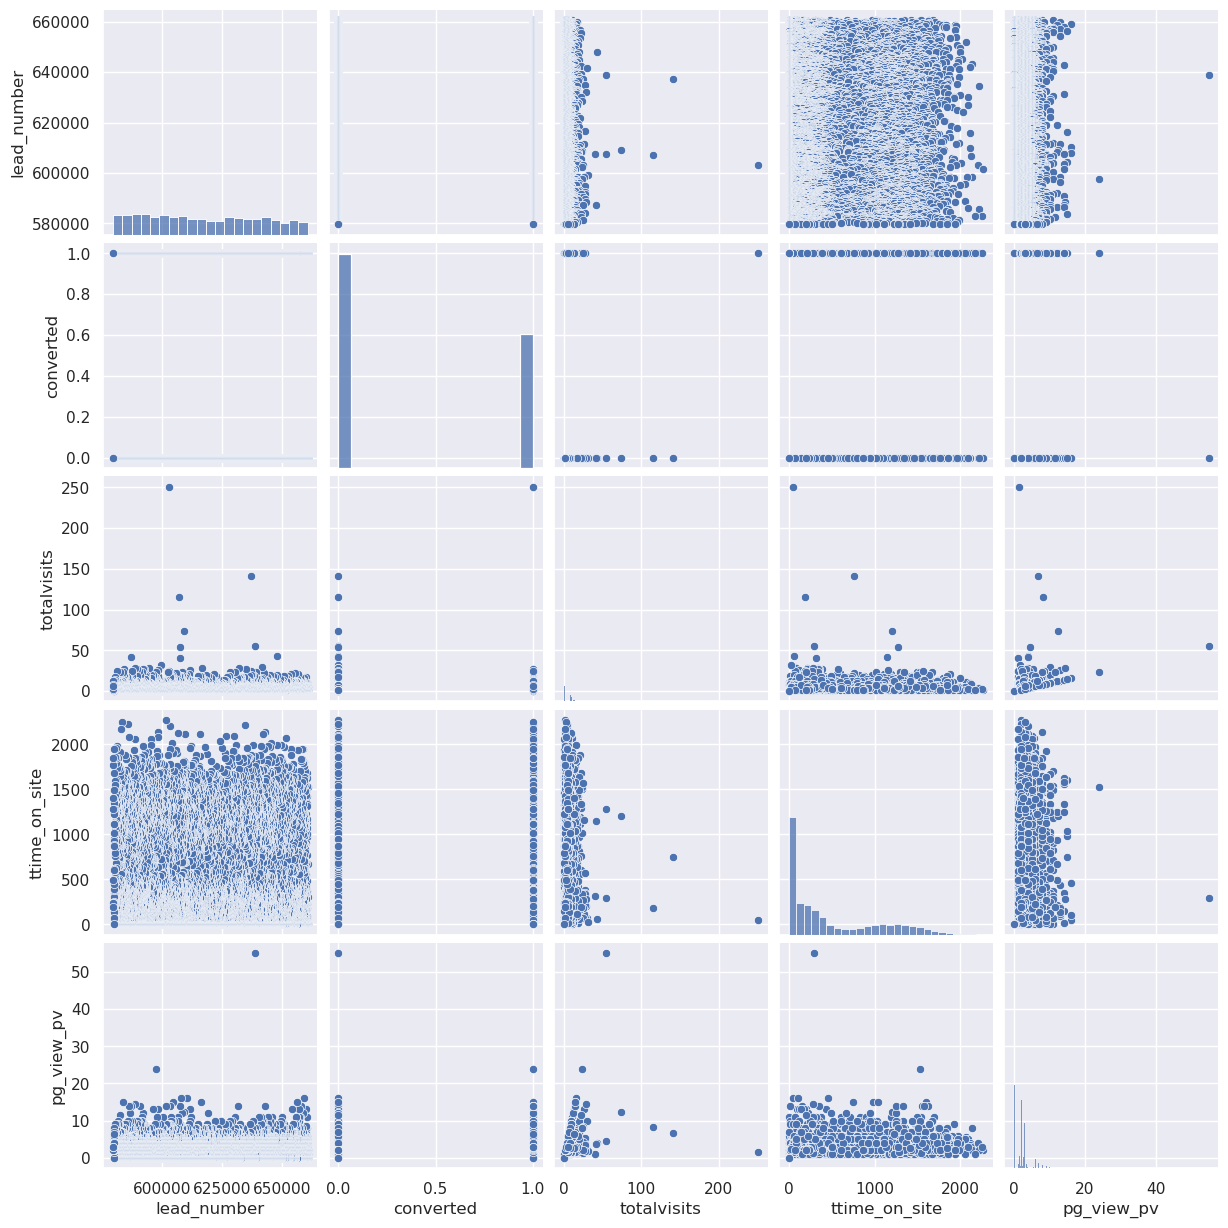

In [67]:
# Bivariate plots
# The pair plot view shows that there is a slight correlation between total visits and page view per visit
sns.pairplot(lead_score_df)
plt.show();

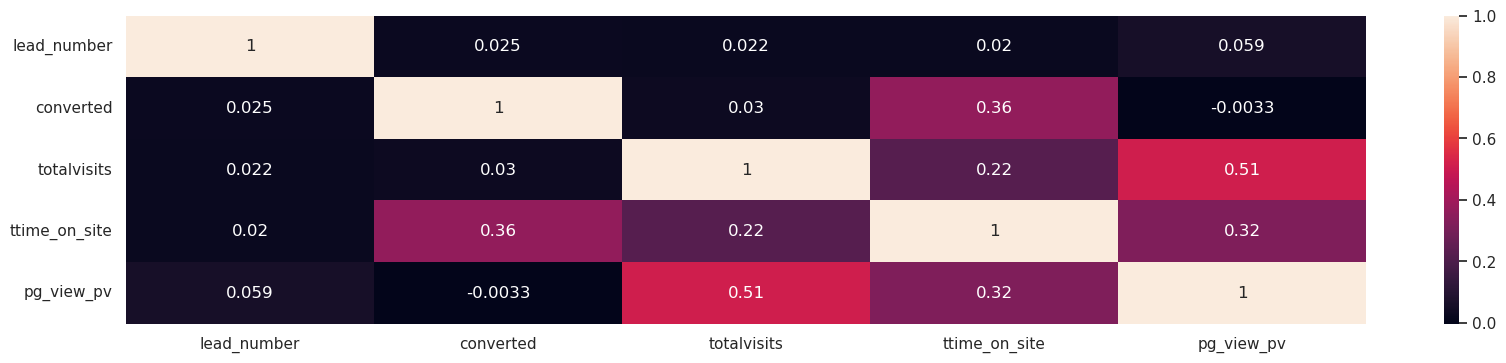

In [68]:
# multivariate plots
# The heat map shows that majority of the features have no correlation or has lesser than 0 5 correlation

plt.figure(figsize = (20, 4)) # Size of the figure
sns.heatmap(lead_score_df.select_dtypes(exclude='category').corr(), annot = True)
plt.show();

#### 3.1 Other Bivariate - Multivariate plots (computationally intensive)

In [69]:
# # Boxplots - numerical features against target

# axs = 141
# plt.figure(figsize=(26, 6))
# for i in list(set(dtype_dict['float_ts']) - set(['date','converted','lead_number'])):
#     plt.subplot(axs)
#     sns.boxplot(y=i, x='converted', data=lead_score_df, palette='tab10')
#     axs += 1
# plt.show();

In [70]:
# # Generate Bivariate Boxplots combinations for all the categorical vs continuous columns
# x_lst = list(dtype_dict['int_cat']) # x_list variable contains all the categorical Columns 
# y_lst = list(dtype_dict['float_ts'])# y_list contains all Continuous feature type columns 

# axs = 1
# for x_col in x_lst:
#     plt.figure(figsize=(26,72))
#     for y_col in y_lst:
#         plt.subplot(18,4,axs)
#         sns.boxplot(x=x_col, y=y_col, data=lead_score_df, palette='tab10')
#         plt.xticks(rotation=90)
#         axs += 1
#     plt.show();
# plt.show();

In [71]:
# # Generate Bivariate Barplots combinations for all the categorical features
# y_lst = x_lst = list(set(dtype_dict['int_cat']) - set(['converted','lead_number'])) # x_list variable contains all the categorical Columns 

# axs = 1
# for x_col in x_lst:
#     plt.figure(figsize=(25,400))
#     for y_col in y_lst:
#         plt.subplot(60,4,axs)
#         sns.barplot(x=x_col, y=y_col, hue ='converted' ,data=lead_score_df, palette='tab10')
#         plt.xticks(rotation=90)
#         axs += 1
#     plt.show();
#     axs = 1
# plt.show();

In [72]:
# # Multivariate Boxplots  - 
# z_lst = x_lst = list(dtype_dict['int_cat'])
# y_lst = list(dtype_dict['float_ts'])
# y_lst.remove('lead_number')

# axs = 1
# for x_col in x_lst:
#     for y_col in y_lst:
#         plt.figure(figsize=(25, 200))
#         for z_col in z_lst:
#             plt.subplot(25, 2, axs)
#             sns.boxplot(x=x_col, y=y_col, hue=z_col,hue_order=lead_score_df[z_col].value_counts().head(10).index ,data=lead_score_df, palette='tab10')
#             plt.xticks(rotation=90)
#             plt.legend(loc='best')
#             axs += 1
#         plt.show();
#     axs = 1
#     print("--------------------------------------------------------------------------")
#     # break
# plt.show();

In [73]:
# # Multivariate Boxplots  - 
# x_lst = list(dtype_dict['int_cat'])
# x_lst.remove('lead_origin')
# x_lst.remove('converted')

# z_lst = y_lst= x_lst

# axs = 1
# for x_col in x_lst:
#     for y_col in y_lst:
#             plt.figure(figsize=(25, 500))
#             for z_col in z_lst:
#                  if (x_col != y_col) & (y_col != z_col) & (x_col != z_col):
#                     plt.subplot(100, 3, axs)
#                     sns.barplot(x=x_col, y=y_col, hue=z_col, hue_order=lead_score_df[z_col].value_counts().head(10).index, data=lead_score_df, palette='tab10')
#                     plt.xticks(rotation=45)
#                     plt.legend(loc='best')
#                     axs += 1
#             plt.show()
#             axs = 1
#     print("--------------------------------------------------------------------------")
#     # break
# plt.show();

###  ----------------------------------------------------------------------

### 4. Data Preprocesing - Part 2

#### Outlier Analysis and Capping

In [74]:
# After performing eda we identified outliers in page view per visit totalvisits ttime on site columns we therefore cap all the values to the upper cut off and lower cut off of the iqr range

ex_val_df = get_extremeval_threshld(df=lead_score_df.select_dtypes(exclude=['category','object']) )
ex_val_df
lead_score_df.describe(percentiles=[.05,.1,.2,.5,.8,.9])

thresh_low  thresh_high
name                                  
lead_number    535130.375   698741.375
converted          -1.500        2.500
totalvisits        -5.000       11.000
ttime_on_site   -1374.000     2322.000
pg_view_pv         -2.000        6.000

lead_number  converted  totalvisits  ttime_on_site  pg_view_pv
count     9240.000   9240.000     9103.000       9240.000    9103.000
mean    617188.436      0.385        3.445        487.698       2.363
std      23405.996      0.487        4.855        548.021       2.161
min     579533.000      0.000        0.000          0.000       0.000
5%      582869.900      0.000        0.000          0.000       0.000
10%     586361.700      0.000        0.000          0.000       0.000
20%     592772.800      0.000        0.000          0.000       0.000
50%     615479.000      0.000        3.000        248.000       2.000
80%     641577.600      1.000        5.000       1087.200       4.000
90%     650506.100      1.000        7.000       1380.000       5.000
max     660737.000      1.000      251.000       2272.000      55.000

In [75]:
# Fix Outliers by setting either thresh low or thresh low for both extremes 
lower_cutoff = ex_val_df.loc['pg_view_pv','thresh_low']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] < lower_cutoff), lower_cutoff, lead_score_df['pg_view_pv'])
upper_cutoff = ex_val_df.loc['pg_view_pv','thresh_high']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] > upper_cutoff), upper_cutoff, lead_score_df['pg_view_pv'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['totalvisits','thresh_low']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] < lower_cutoff), lower_cutoff, lead_score_df['totalvisits'])
upper_cutoff = ex_val_df.loc['totalvisits','thresh_high']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] > upper_cutoff), upper_cutoff, lead_score_df['totalvisits'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['ttime_on_site','thresh_low']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] < lower_cutoff), lower_cutoff, lead_score_df['ttime_on_site'])
upper_cutoff = ex_val_df.loc['ttime_on_site','thresh_high']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] > upper_cutoff), upper_cutoff, lead_score_df['ttime_on_site'])

In [76]:
lead_score_df.describe()

lead_number  converted  totalvisits  ttime_on_site  pg_view_pv
count     9240.000   9240.000     9103.000       9240.000    9103.000
mean    617188.436      0.385        3.221        487.698       2.259
std      23405.996      0.487        2.882        548.021       1.793
min     579533.000      0.000        0.000          0.000       0.000
25%     596484.500      0.000        1.000         12.000       1.000
50%     615479.000      0.000        3.000        248.000       2.000
75%     637387.250      1.000        5.000        936.000       3.000
max     660737.000      1.000       11.000       2272.000       6.000

In [77]:
# Additionally there are few null values in their total visits and page view pub features therefore we replace with the mean of that particular column

lead_score_df['totalvisits'] = lead_score_df['totalvisits'].replace(to_replace=np.nan, value=lead_score_df['totalvisits'].mean())
lead_score_df['pg_view_pv'] = lead_score_df['pg_view_pv'].replace(to_replace=np.nan, value=lead_score_df['pg_view_pv'].mean())

In [78]:
# replace Yes, No with 1 and 0
lead_score_df = lead_score_df.replace(to_replace=['Yes', 'No'], value=[1, 0])

In [79]:
# our null values have significantly reduced
check_cols_null_pct(lead_score_df)
lead_score_df.shape

specialization         36.580
tags                   36.288
last_activity           1.115
lead_source             0.390
lead_number             0.000
lead_origin             0.000
do_not_email            0.000
converted               0.000
totalvisits             0.000
ttime_on_site           0.000
pg_view_pv              0.000
country                 0.000
curr_occupation         0.000
reason_behind_course    0.000
city                    0.000
avail_free_copy         0.000
dtype: float64

(9240, 16)

In [80]:
lead_score_df.last_activity = lead_score_df.last_activity.fillna(lead_score_df.last_activity.mode()[0])
lead_score_df.last_activity.value_counts(normalize=True) * 100

lead_score_df.lead_source = lead_score_df.lead_source.fillna(lead_score_df.lead_source.mode()[0])
lead_score_df.lead_source.value_counts(normalize=True) * 100

last_activity
Email Opened                   38.312
SMS Sent                       29.708
Olark Chat Conversation        10.530
Page Visited on Website         6.926
Converted to Lead               4.632
Email Bounced                   3.528
Email Link Clicked              2.890
Form Submitted on Website       1.255
Unreachable                     1.006
Unsubscribed                    0.660
Had a Phone Conversation        0.325
Approached upfront              0.097
View in browser link Clicked    0.065
Email Received                  0.022
Email Marked Spam               0.022
Resubscribed to emails          0.011
Visited Booth in Tradeshow      0.011
Name: proportion, dtype: float64

lead_source
Google              31.429
Direct Traffic      27.522
Olark Chat          18.994
Organic Search      12.489
Reference            5.779
Welingak Website     1.537
Referral Sites       1.353
Facebook             0.595
bing                 0.065
google               0.054
Click2call           0.043
Press_Release        0.022
Social Media         0.022
Live Chat            0.022
WeLearn              0.011
Pay per Click Ads    0.011
NC_EDM               0.011
blog                 0.011
testone              0.011
welearnblog_Home     0.011
youtubechannel       0.011
Name: proportion, dtype: float64

In [81]:
# lead_score_df.to_csv('spec_tag_analysis.csv')

lead_score_df = lead_score_df.drop(['specialization','tags'], axis=1)
check_cols_null_pct(lead_score_df)
lead_score_df.shape

lead_number            0.000
lead_origin            0.000
lead_source            0.000
do_not_email           0.000
converted              0.000
totalvisits            0.000
ttime_on_site          0.000
pg_view_pv             0.000
last_activity          0.000
country                0.000
curr_occupation        0.000
reason_behind_course   0.000
city                   0.000
avail_free_copy        0.000
dtype: float64

(9240, 14)

In [82]:
lead_score_df.dtypes

lead_number                int64
lead_origin             category
lead_source             category
do_not_email            category
converted                  int64
totalvisits              float64
ttime_on_site            float64
pg_view_pv               float64
last_activity           category
country                 category
curr_occupation         category
reason_behind_course    category
city                    category
avail_free_copy         category
dtype: object

###  ----------------------------------------------------------------------

### 5. Data Imbalance & Conversion Ratio

In [83]:
# Data Imbalance
# From the target variable we have found out the imbalance ratios around 62 therefore we decide not to rebalance

imbalance_ratio = sum(lead_score_df['converted'] == 1)/sum(lead_score_df['converted'] == 0) * 100
print(f'{round(imbalance_ratio, 2)}%')

62.7%


In [84]:
# Conversion Ratio 
# From the target variable the conversion ratio is around 38 it shows that there is a very high probability of failure in conversion

converted = (sum(lead_score_df['converted'])/len(lead_score_df['converted'].index))*100
print(f'{round(converted, 2)}%')

38.54%


##  -----------------------------------------------------

In [85]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## -----------------------------------------------------

## Approach - 01

### Data Encoding

#### Dummy Encoding

In [41]:
#  we perform dummy encoding
new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns, drop_first=True, dtype=float)
new_ls_df.head(1)

lead_number  converted  totalvisits  ttime_on_site  pg_view_pv  \
0       660737          0        0.000          0.000       0.000   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                0.000                      0.000   

   lead_origin_Lead Import  lead_origin_Quick Add Form  \
0                    0.000                       0.000   

   lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
0                       0.000                 0.000               0.000   

   lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
0                  0.000               0.000                   1.000   

   lead_source_Organic Search  lead_source_Pay per Click Ads  \
0                       0.000                          0.000   

   lead_source_Press_Release  lead_source_Reference  \
0                      0.000                  0.000   

   lead_source_Referral Sites  lead_source_Social Media  lead_source_WeLearn  \
0                       0.000                     0.000                0.000   

   lead_source_Welingak Website  lead_source_bing  lead_source_blog  \
0                         0.000             0.000             0.000   

   lead_source_google  lead_source_testone  lead_source_welearnblog_Home  \
0               0.000                0.000                         0.000   

   lead_source_youtubechannel  do_not_email_1  \
0                       0.000           0.000   

   last_activity_Converted to Lead  last_activity_Email Bounced  \
0                            0.000                        0.000   

   last_activity_Email Link Clicked  last_activity_Email Marked Spam  \
0                             0.000                            0.000   

   last_activity_Email Opened  last_activity_Email Received  \
0                       0.000                         0.000   

   last_activity_Form Submitted on Website  \
0                                    0.000   

   last_activity_Had a Phone Conversation  \
0                                   0.000   

   last_activity_Olark Chat Conversation  \
0                                  0.000   

   last_activity_Page Visited on Website  \
0                                  1.000   

   last_activity_Resubscribed to emails  last_activity_SMS Sent  \
0                                 0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
0                      0.000                       0.000   

   last_activity_View in browser link Clicked  \
0                                       0.000   

   last_activity_Visited Booth in Tradeshow  country_Australia  \
0                                     0.000              0.000   

   country_Bahrain  country_Bangladesh  country_Belgium  country_Canada  \
0            0.000               0.000            0.000           0.000   

   country_China  country_Denmark  country_France  country_Germany  \
0          0.000            0.000           0.000            0.000   

   country_Ghana  country_Hong Kong  country_India  country_Indonesia  \
0          0.000              0.000          1.000              0.000   

   country_Italy  country_Kenya  country_Kuwait  country_Liberia  \
0          0.000          0.000           0.000            0.000   

   country_Malaysia  country_Netherlands  country_Nigeria  country_Oman  \
0             0.000                0.000            0.000         0.000   

   country_Philippines  country_Qatar  country_Russia  country_Saudi Arabia  \
0                0.000          0.000           0.000                 0.000   

   country_Singapore  country_South Africa  country_Sri Lanka  country_Sweden  \
0              0.000                 0.000              0.000           0.000   

   country_Switzerland  country_Tanzania  country_Uganda  \
0                0.000             0.000           0.000   

   country_United Arab Emirates  country_United Kingdom  \
0                         0.00

###  ----------------------------------------------------------------------

### Train and Test Split

In [42]:
X = new_ls_df.drop(['lead_number','converted'], axis=1)
y = new_ls_df['converted']

In [43]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

###  ----------------------------------------------------------------------

### Feature Scaling

In [44]:
new_ls_df.dtypes

lead_number                                         int64
converted                                           int64
totalvisits                                       float64
ttime_on_site                                     float64
pg_view_pv                                        float64
lead_origin_Landing Page Submission               float64
lead_origin_Lead Add Form                         float64
lead_origin_Lead Import                           float64
lead_origin_Quick Add Form                        float64
lead_source_Direct Traffic                        float64
lead_source_Facebook                              float64
lead_source_Google                                float64
lead_source_Live Chat                             float64
lead_source_NC_EDM                                float64
lead_source_Olark Chat                            float64
lead_source_Organic Search                        float64
lead_source_Pay per Click Ads                     float64
lead_source_Pr

In [45]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = list(X.columns)
to_scale

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head()

['totalvisits',
 'ttime_on_site',
 'pg_view_pv',
 'lead_origin_Landing Page Submission',
 'lead_origin_Lead Add Form',
 'lead_origin_Lead Import',
 'lead_origin_Quick Add Form',
 'lead_source_Direct Traffic',
 'lead_source_Facebook',
 'lead_source_Google',
 'lead_source_Live Chat',
 'lead_source_NC_EDM',
 'lead_source_Olark Chat',
 'lead_source_Organic Search',
 'lead_source_Pay per Click Ads',
 'lead_source_Press_Release',
 'lead_source_Reference',
 'lead_source_Referral Sites',
 'lead_source_Social Media',
 'lead_source_WeLearn',
 'lead_source_Welingak Website',
 'lead_source_bing',
 'lead_source_blog',
 'lead_source_google',
 'lead_source_testone',
 'lead_source_welearnblog_Home',
 'lead_source_youtubechannel',
 'do_not_email_1',
 'last_activity_Converted to Lead',
 'last_activity_Email Bounced',
 'last_activity_Email Link Clicked',
 'last_activity_Email Marked Spam',
 'last_activity_Email Opened',
 'last_activity_Email Received',
 'last_activity_Form Submitted on Website',
 'last_a

totalvisits  ttime_on_site  pg_view_pv  \
7263       -1.128         -0.885      -1.272   
6468       -0.429         -0.632      -0.146   
7833       -0.429         -0.740      -0.146   
4461        0.269          2.007       0.980   
8453       -1.128         -0.885      -1.272   

      lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
7263                               -1.062                     -0.293   
6468                                0.942                     -0.293   
7833                                0.942                     -0.293   
4461                                0.942                     -0.293   
8453                               -1.062                     -0.293   

      lead_origin_Lead Import  lead_origin_Quick Add Form  \
7263                   -0.074                      -0.012   
6468                   -0.074                      -0.012   
7833                   -0.074                      -0.012   
4461                   -0.074                      -0.012   
8453                   -0.074                      -0.012   

      lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
7263                      -0.616                -0.074              -0.682   
6468                       1.625                -0.074              -0.682   
7833                       1.625                -0.074              -0.682   
4461                      -0.616                -0.074               1.465   
8453                      -0.616                -0.074              -0.682   

      lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
7263                 -0.016              -0.012                   2.075   
6468                 -0.016              -0.012                  -0.482   
7833                 -0.016              -0.012                  -0.482   
4461                 -0.016              -0.012                  -0.482   
8453                 -0.016              -0.012                   2.075   

      lead_source_Organic Search  lead_source_Pay per Click Ads  \
7263                      -0.372                         -0.012   
6468                      -0.372                         -0.012   
7833                      -0.372                         -0.012   
4461                      -0.372                         -0.012   
8453                      -0.372                         -0.012   

      lead_source_Press_Release  lead_source_Reference  \
7263                     -0.016                 -0.252   
6468                     -0.016                 -0.252   
7833                     -0.016                 -0.252   
4461                     -0.016                 -0.252   
8453                     -0.016                 -0.252   

      lead_source_Referral Sites  lead_source_Social Media  \
7263                      -0.121                    -0.016   
6468                      -0.121                    -0.016   
7833                      -0.121                    -0.016   
4461                      -0.121                    -0.016   
8453                      -0.121                    -0.016   

      lead_source_WeLearn  lead_source_Welingak Website  lead_source_bing  \
7263               -0.012                        -0.121            -0.023   
6468               -0.012                        -0.121            -0.023   
7833               -0.012                        -0.121            -0.023   
4461               -0.012                        -0.121            -0.023   
8453               -0.012                        -0.121            -0.023   

      lead_source_blog  lead_source_google  lead_source_testone  \
7263            -0.012              -0.026                0.000   
6468            -0.012              -0.026                0.000   
7833            -0.012              -0.026                0.000   
4461            -0.012              -0.026                0.000   
8453            -0.012              -0.026                0.000   

      

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [46]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [47]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7302
Model Family:                Binomial   Df Model:                           89
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3036.0
Date:                Thu, 17 Oct 2024   Deviance:                       6071.9
Time:                        01:30:55   Pearson chi2:                 1.04e+04
No. Iterations:                    23   Pseudo R-squ. (CS):             0.3991
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.6516    145.582     -0.004      0.996    -285.987     284.684
totalvisits                                        0.3697      0.050      7.397      0.000       0.272       0.468
ttime_on_site                                      1.0891      0.037     29.179      0.000       1.016       1.162
pg_view_pv                                        -0.3112      0.056     -5.532      0.000      -0.422      -0.201
lead_origin_Landing Page Submission               -0.1039      0.051     -2.025      0.043      -0.204      -0.003
lead_origin_Lead Add Form                          0.8443      0.141      5.984      0.000       0.568       1.121
lead_origin_Lead Import                            0.0227      0.152      0.149      0.882      -0.276       0.321
lead_origin_Quick Add Form                         0.2776   1332.685      0.000      1.000   -2611.737    2612.292
lead_source_Direct Traffic                         0.1711      0.605      0.283      0.777      -1.015       1.357
lead_source_Facebook                              -0.0067      0.182     -0.037      0.970      -0.363       0.350
lead_source_Google                                 0.2982      0.629      0.474      0.636      -0.935       1.532
lead_source_Live Chat                              0.3729   1316.488      0.000      1.000   -2579.897    2580.643
lead_source_NC_EDM                                 0.2987   2104.331      0.000      1.000   -4124.114    4124.711
lead_source_Olark Chat                             0.6060      0.531      1.141      0.254      -0.435       1.647
lead_source_Organic Search                         0.1535      0.444      0.346      0.729      -0.716       1.023
lead_source_Pay per Click Ads                     -0.2595   1766.965     -0.000      1.000   -3463.448    3462.929
lead_source_Press_Release                         -0.3458   1030.777     -0.000      1.000   -2020.632    2019.940
lead_source_Reference                              0.2068      0.299      0.691      0.489      -0.380       0.793
lead_source_Referral Sites                         0.0359      0.165      0.217      0.828      -0.288       0.360
lead_source_Social Media                           0.0478      0.033      1.467      0.142      -0.016       0.112
lead_source_WeLearn                                0.2900   1507.639      0.000      1.000   -2954.628    2955.208
lead_source_Welingak Website                       0.3708      0.173      2.147      0.032       0.032       0.709
lead_source_bing                                   0.0317      0.043      0.731      0.465      -0.053       0.117
lead_source_blog                                  -0.2620   1322.903     -0.000      1.000   

##### RFE - Recursive Feature Elimination

In [48]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('totalvisits', True, 1),
 ('ttime_on_site', True, 1),
 ('pg_view_pv', True, 1),
 ('lead_origin_Landing Page Submission', False, 20),
 ('lead_origin_Lead Add Form', True, 1),
 ('lead_origin_Lead Import', False, 54),
 ('lead_origin_Quick Add Form', False, 18),
 ('lead_source_Direct Traffic', False, 49),
 ('lead_source_Facebook', False, 53),
 ('lead_source_Google', False, 9),
 ('lead_source_Live Chat', False, 13),
 ('lead_source_NC_EDM', False, 19),
 ('lead_source_Olark Chat', True, 1),
 ('lead_source_Organic Search', False, 66),
 ('lead_source_Pay per Click Ads', False, 39),
 ('lead_source_Press_Release', False, 17),
 ('lead_source_Reference', False, 8),
 ('lead_source_Referral Sites', False, 60),
 ('lead_source_Social Media', False, 47),
 ('lead_source_WeLearn', False, 16),
 ('lead_source_Welingak Website', True, 1),
 ('lead_source_bing', False, 58),
 ('lead_source_blog', False, 29),
 ('lead_source_google', False, 4),
 ('lead_source_testone', False, 79),
 ('lead_source_welearnblog_Hom

In [49]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['lead_origin_Landing Page Submission', 'lead_origin_Lead Import',
       'lead_origin_Quick Add Form', 'lead_source_Direct Traffic',
       'lead_source_Facebook', 'lead_source_Google', 'lead_source_Live Chat',
       'lead_source_NC_EDM', 'lead_source_Organic Search',
       'lead_source_Pay per Click Ads', 'lead_source_Press_Release',
       'lead_source_Reference', 'lead_source_Referral Sites',
       'lead_source_Social Media', 'lead_source_WeLearn', 'lead_source_bing',
       'lead_source_blog', 'lead_source_google', 'lead_source_testone',
       'lead_source_welearnblog_Home', 'lead_source_youtubechannel',
       'last_activity_Email Marked Spam', 'last_activity_Email Received',
       'last_activity_Form Submitted on Website',
       'last_activity_Had a Phone Conversation',
       'last_activity_Resubscribed to emails', 'last_activity_SMS Sent',
       'last_activity_Unreachable', 'last_activity_Unsubscribed',
       'last_activity_View in browser link Clicked',
       '

##### Model 2

In [50]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7376
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3107.5
Date:                Thu, 17 Oct 2024   Deviance:                       6215.0
Time:                        01:30:59   Pearson chi2:                 9.06e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3874
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.5733     16.929     -0.034      0.973     -33.753      32.607
totalvisits                               0.3521      0.048      7.309      0.000       0.258       0.447
ttime_on_site                             1.1050      0.037     30.022      0.000       1.033       1.177
pg_view_pv                               -0.3090      0.054     -5.772      0.000      -0.414      -0.204
lead_origin_Lead Add Form                 0.9777      0.052     18.917      0.000       0.876       1.079
lead_source_Olark Chat                    0.4521      0.047      9.647      0.000       0.360       0.544
lead_source_Welingak Website              0.2660      0.089      2.990      0.003       0.092       0.440
do_not_email_1                           -0.3578      0.048     -7.483      0.000      -0.452      -0.264
last_activity_Converted to Lead          -0.4909      0.044    -11.170      0.000      -0.577      -0.405
last_activity_Email Bounced              -0.3727      0.062     -6.046      0.000      -0.493      -0.252
last_activity_Email Link Clicked         -0.2639      0.033     -7.878      0.000      -0.330      -0.198
last_activity_Email Opened               -0.5139      0.035    -14.777      0.000      -0.582      -0.446
last_activity_Olark Chat Conversation    -0.7931      0.048    -16.517      0.000      -0.887      -0.699
last_activity_Page Visited on Website    -0.4735      0.038    -12.582      0.000      -0.547      -0.400
curr_occupation_Housewife                 0.7949    484.870      0.002      0.999    -949.533     951.122
curr_occupation_Working Professional      0.7627      0.047     16.246      0.000       0.671       0.855
=========================================================================================================
"""


VIF Score:


Features   VIF
2                              pg_view_pv 2.980
0                             totalvisits 2.540
4                  lead_source_Olark Chat 2.200
6                          do_not_email_1 1.730
8             last_activity_Email Bounced 1.690
3               lead_origin_Lead Add Form 1.660
11  last_activity_Olark Chat Conversation 1.450
10             last_activity_Email Opened 1.390
1                           ttime_on_site 1.270
5            lead_source_Welingak Website 1.230
12  last_activity_Page Visited on Website 1.210
7         last_activity_Converted to Lead 1.190
14   curr_occupation_Working Professional 1.090
9        last_activity_Email Link Clicked 1.070
13              curr_occupation_Housewife 1.000

In [51]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:


Confusion Matrix:


array([[4077,  486],
       [ 954, 1875]])


Accuracy Score: 0.8051948051948052



##### Model 3

In [52]:
col = col.drop('curr_occupation_Housewife', 1)
col

Index(['totalvisits', 'ttime_on_site', 'pg_view_pv',
       'lead_origin_Lead Add Form', 'lead_source_Olark Chat',
       'lead_source_Welingak Website', 'do_not_email_1',
       'last_activity_Converted to Lead', 'last_activity_Email Bounced',
       'last_activity_Email Link Clicked', 'last_activity_Email Opened',
       'last_activity_Olark Chat Conversation',
       'last_activity_Page Visited on Website',
       'curr_occupation_Working Professional'],
      dtype='object')

In [53]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7377
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3113.9
Date:                Thu, 17 Oct 2024   Deviance:                       6227.8
Time:                        01:30:59   Pearson chi2:                 9.10e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3863
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.5972      0.036    -16.382      0.000      -0.669      -0.526
totalvisits                               0.3497      0.048      7.265      0.000       0.255       0.444
ttime_on_site                             1.1045      0.037     30.033      0.000       1.032       1.177
pg_view_pv                               -0.3093      0.054     -5.782      0.000      -0.414      -0.204
lead_origin_Lead Add Form                 0.9809      0.052     19.010      0.000       0.880       1.082
lead_source_Olark Chat                    0.4484      0.047      9.581      0.000       0.357       0.540
lead_source_Welingak Website              0.2635      0.089      2.961      0.003       0.089       0.438
do_not_email_1                           -0.3584      0.048     -7.492      0.000      -0.452      -0.265
last_activity_Converted to Lead          -0.4916      0.044    -11.188      0.000      -0.578      -0.405
last_activity_Email Bounced              -0.3728      0.062     -6.046      0.000      -0.494      -0.252
last_activity_Email Link Clicked         -0.2622      0.033     -7.867      0.000      -0.328      -0.197
last_activity_Email Opened               -0.5109      0.035    -14.709      0.000      -0.579      -0.443
last_activity_Olark Chat Conversation    -0.7926      0.048    -16.508      0.000      -0.887      -0.698
last_activity_Page Visited on Website    -0.4732      0.038    -12.579      0.000      -0.547      -0.399
curr_occupation_Working Professional      0.7614      0.047     16.219      0.000       0.669       0.853
=========================================================================================================
"""


VIF Score:


Features   VIF
2                              pg_view_pv 2.980
0                             totalvisits 2.540
4                  lead_source_Olark Chat 2.200
6                          do_not_email_1 1.730
8             last_activity_Email Bounced 1.690
3               lead_origin_Lead Add Form 1.660
11  last_activity_Olark Chat Conversation 1.450
10             last_activity_Email Opened 1.390
1                           ttime_on_site 1.270
5            lead_source_Welingak Website 1.230
12  last_activity_Page Visited on Website 1.210
7         last_activity_Converted to Lead 1.190
13   curr_occupation_Working Professional 1.090
9        last_activity_Email Link Clicked 1.070

In [54]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:


Confusion Matrix:


array([[4077,  486],
       [ 957, 1872]])


Accuracy Score: 0.804788961038961



####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [55]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           1       0.248  7263           0      1      1      1      0   
1           0       0.264  6468           0      1      1      1      0   
2           1       0.241  7833           0      1      1      1      0   
3           0       0.856  4461           1      1      1      1      1   
4           0       0.065  8453           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900  
0      0      0      0      0      0      0  
1      0      0      0      0      0      0  
2      0      0      0      0      0      0  
3      1      1      1      1      1      0  
4      0      0      0      0      0      0

In [56]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.383  1.000  0.000
0.100 0.100     0.602  0.970  0.374
0.200 0.200     0.727  0.931  0.601
0.300 0.300     0.798  0.828  0.780
0.400 0.400     0.817  0.768  0.847
0.500 0.500     0.805  0.662  0.893
0.600 0.600     0.794  0.590  0.921
0.700 0.700     0.780  0.513  0.945
0.800 0.800     0.746  0.384  0.971
0.900 0.900     0.714  0.271  0.988


<Axes: xlabel='prob'>

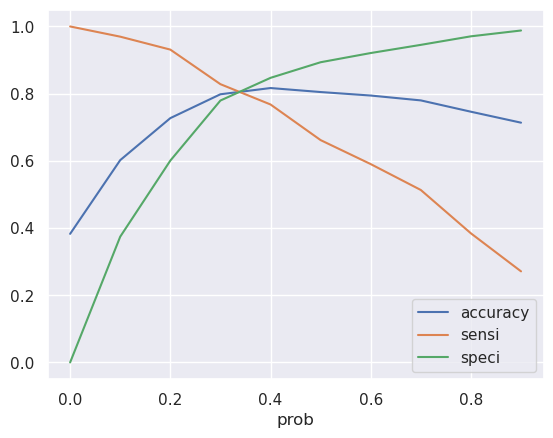

In [57]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [58]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.35 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           1       0.248  7263           0      1      1      1      0   
1           0       0.264  6468           0      1      1      1      0   
2           1       0.241  7833           0      1      1      1      0   
3           0       0.856  4461           1      1      1      1      1   
4           0       0.065  8453           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      0      0      0      0      0      0                 0  
2      0      0      0      0      0      0                 0  
3      1      1      1      1      1      0                 1  
4      0      0      0      0      0      0                 0

In [59]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8106060606060606

In [60]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3740,  823],
       [ 577, 2252]])

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

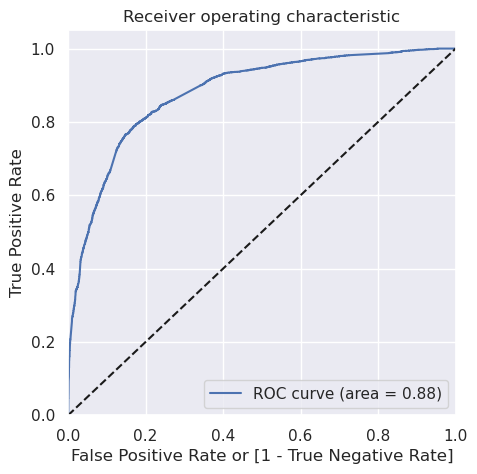

In [61]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [62]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7938931297709924

0.6617179215270413

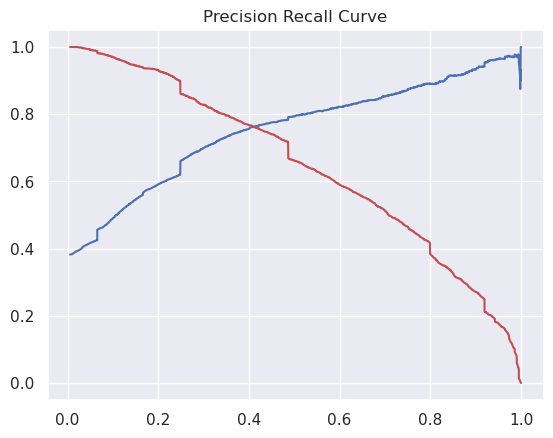

In [63]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

###  ---------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [64]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [65]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

totalvisits  ttime_on_site  pg_view_pv  lead_origin_Lead Add Form  \
4269        1.667          0.967       2.106                     -0.293   
2376       -1.128         -0.885      -1.272                      3.411   
7766        0.619         -0.777       1.543                     -0.293   
9199       -1.128         -0.885      -1.272                     -0.293   
4359       -1.128         -0.885      -1.272                      3.411   

      lead_source_Olark Chat  lead_source_Welingak Website  do_not_email_1  \
4269                  -0.482                        -0.121          -0.293   
2376                  -0.482                        -0.121          -0.293   
7766                  -0.482                        -0.121          -0.293   
9199                   2.075                        -0.121          -0.293   
4359                  -0.482                        -0.121          -0.293   

      last_activity_Converted to Lead  last_activity_Email Bounced  \
4269                           -0.222                       -0.191   
2376                           -0.222                       -0.191   
7766                           -0.222                       -0.191   
9199                           -0.222                       -0.191   
4359                           -0.222                       -0.191   

      last_activity_Email Link Clicked  last_activity_Email Opened  \
4269                            -0.173                      -0.784   
2376                            -0.173                      -0.784   
7766                            -0.173                      -0.784   
9199                            -0.173                      -0.784   
4359                            -0.173                       1.276   

      last_activity_Olark Chat Conversation  \
4269                                 -0.340   
2376                                 -0.340   
7766                                 -0.340   
9199                                  2.945   
4359                                 -0.340   

      last_activity_Page Visited on Website  \
4269                                 -0.276   
2376                                 -0.276   
7766                                 -0.276   
9199                                 -0.276   
4359                                 -0.276   

      curr_occupation_Working Professional  
4269                                -0.290  
2376                                -0.290  
7766                                 3.450  
9199                                -0.290  
4359                                -0.290

In [66]:
cutoff = 0.3
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif


Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7377
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3113.9
Date:                Thu, 17 Oct 2024   Deviance:                       6227.8
Time:                        01:31:00   Pearson chi2:                 9.10e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3863
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.5972      0.036    -16.382      0.000      -0.669      -0.526
totalvisits                               0.3497      0.048      7.265      0.000       0.255       0.444
ttime_on_site                             1.1045      0.037     30.033      0.000       1.032       1.177
pg_view_pv                               -0.3093      0.054     -5.782      0.000      -0.414      -0.204
lead_origin_Lead Add Form                 0.9809      0.052     19.010      0.000       0.880       1.082
lead_source_Olark Chat                    0.4484      0.047      9.581      0.000       0.357       0.540
lead_source_Welingak Website              0.2635      0.089      2.961      0.003       0.089       0.438
do_not_email_1                           -0.3584      0.048     -7.492      0.000      -0.452      -0.265
last_activity_Converted to Lead          -0.4916      0.044    -11.188      0.000      -0.578      -0.405
last_activity_Email Bounced              -0.3728      0.062     -6.046      0.000      -0.494      -0.252
last_activity_Email Link Clicked         -0.2622      0.033     -7.867      0.000      -0.328      -0.197
last_activity_Email Opened               -0.5109      0.035    -14.709      0.000      -0.579      -0.443
last_activity_Olark Chat Conversation    -0.7926      0.048    -16.508      0.000      -0.887      -0.698
last_activity_Page Visited on Website    -0.4732      0.038    -12.579      0.000      -0.547      -0.399
curr_occupation_Working Professional      0.7614      0.047     16.219      0.000       0.669       0.853
=========================================================================================================
"""


VIF Score:


Features   VIF
2                              pg_view_pv 3.140
0                             totalvisits 2.650
4                  lead_source_Olark Chat 2.310
3               lead_origin_Lead Add Form 1.850
6                          do_not_email_1 1.700
8             last_activity_Email Bounced 1.660
11  last_activity_Olark Chat Conversation 1.450
10             last_activity_Email Opened 1.420
5            lead_source_Welingak Website 1.380
1                           ttime_on_site 1.350
7         last_activity_Converted to Lead 1.170
12  last_activity_Page Visited on Website 1.170
13   curr_occupation_Working Professional 1.110
9        last_activity_Email Link Clicked 1.070

In [67]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[852, 264],
       [138, 594]])


Accuracy Score: 0.7824675324675324



## -----------------------------------------------------

In [68]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## -----------------------------------------------------

## Approach - 02

### Data Encoding

#### Label Encoding

In [402]:
# for label_encoding:
# Since there are many categorical features with nominal values 5 we decide to use label encoding for those features

cols_to_le = [i for i in lead_score_df.columns if ((lead_score_df[i].dtype == 'category') and len(lead_score_df[i].unique()) > 5)]
cols_to_le

['lead_source', 'last_activity', 'country', 'curr_occupation', 'city']

In [403]:
le = LabelEncoder()
df_le = lead_score_df[cols_to_le].apply(le.fit_transform)

<Figure size 1000x600 with 0 Axes>

<Axes: >

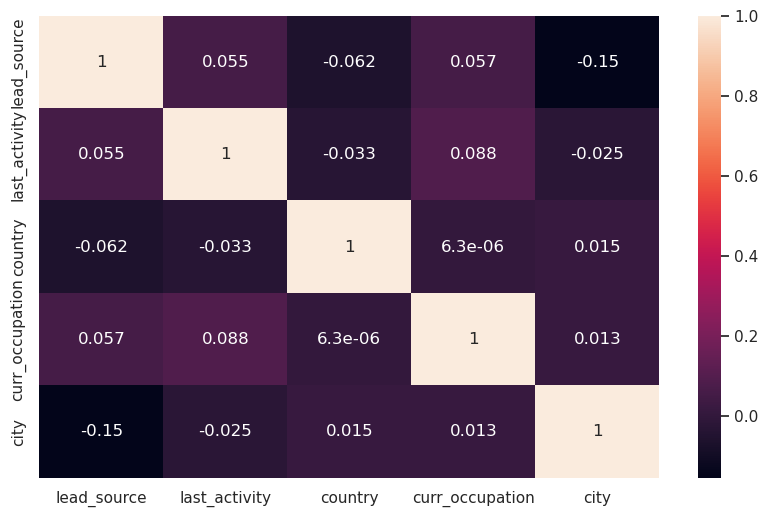

In [404]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_le.corr(), annot=True)

In [405]:
# We then merged the encoder features with the non encoded features and name it as new lsdf

new_ls_df = lead_score_df[lead_score_df.columns.difference(cols_to_le)]
new_ls_df = new_ls_df.merge(right=df_le, right_index=True, left_index=True)
new_ls_df.head()

avail_free_copy  converted do_not_email  lead_number  \
0               0          0            0       660737   
1               0          0            0       660728   
2               1          1            0       660727   
3               0          0            0       660719   
4               0          1            0       660681   

               lead_origin  pg_view_pv     reason_behind_course  totalvisits  \
0                      API       0.000  Better Career Prospects        0.000   
1                      API       2.500  Better Career Prospects        5.000   
2  Landing Page Submission       2.000  Better Career Prospects        2.000   
3  Landing Page Submission       1.000  Better Career Prospects        1.000   
4  Landing Page Submission       1.000  Better Career Prospects        2.000   

   ttime_on_site  lead_source  last_activity  country  curr_occupation  city  
0          0.000            6             10       12                4     0  
1        674.000            7              5       12                4     0  
2       1532.000            1              5       12                3     0  
3        305.000            1             13       12                4     0  
4       1428.000            3              1       12                4     0

In [406]:
# our null values have significantly reduced
check_cols_null_pct(new_ls_df)
new_ls_df.shape

avail_free_copy        0.000
converted              0.000
do_not_email           0.000
lead_number            0.000
lead_origin            0.000
pg_view_pv             0.000
reason_behind_course   0.000
totalvisits            0.000
ttime_on_site          0.000
lead_source            0.000
last_activity          0.000
country                0.000
curr_occupation        0.000
city                   0.000
dtype: float64

(9240, 14)

In [407]:
# new_ls_df = new_ls_df[(new_ls_df.notna()).all(axis=1)]
# check_cols_null_pct(new_ls_df)
# sorted([f'{i} - {new_ls_df[i].unique()}' for i in new_ls_df.columns])

#### Dummy Encoding

In [408]:
# for label_encoding:
# For those columns that are lesser than 5 labels we perform dummy ecoding

cols_to_de = [i for i in new_ls_df.columns if ((new_ls_df[i].dtype == 'category') and len(new_ls_df[i].unique()) <= 5)]
cols_to_de
new_ls_df = pd.get_dummies(new_ls_df, columns=cols_to_de, drop_first=True, dtype=float)

['avail_free_copy', 'do_not_email', 'lead_origin', 'reason_behind_course']

In [409]:
new_ls_df.head(1)

converted  lead_number  pg_view_pv  totalvisits  ttime_on_site  \
0          0       660737       0.000        0.000          0.000   

   lead_source  last_activity  country  curr_occupation  city  \
0            6             10       12                4     0   

   avail_free_copy_1  do_not_email_1  lead_origin_Landing Page Submission  \
0              0.000           0.000                                0.000   

   lead_origin_Lead Add Form  lead_origin_Lead Import  \
0                      0.000                    0.000   

   lead_origin_Quick Add Form  reason_behind_course_Flexibility & Convenience  \
0                       0.000                                           0.000   

   reason_behind_course_Other  
0                       0.000

###  ----------------------------------------------------------------------

### Train and Test Split

In [410]:
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [411]:
# Now we split the dataset into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

###  ----------------------------------------------------------------------

### Feature Scaling

In [412]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv', 'lead_source', 'last_activity', 'country', 'curr_occupation']

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale],y_train)
X_train.head()

lead_number  pg_view_pv  totalvisits  ttime_on_site  lead_source  \
7263       -0.994      -1.272       -1.128         -0.885        0.587   
6468       -0.716      -0.146       -0.429         -0.632       -1.059   
7833       -1.169      -0.146       -0.429         -0.740       -1.059   
4461       -0.010       0.980        0.269          2.007       -0.401   
8453       -1.355      -1.272       -1.128         -0.885        0.587   

      last_activity  country  curr_occupation  city  avail_free_copy_1  \
7263         -0.734   -0.137           -0.134     0              0.000   
6468          1.178   -0.137           -0.134     0              1.000   
7833          1.178   -0.137           -0.134     1              1.000   
4461          1.178   -0.137           -0.134     0              0.000   
8453          0.359   -0.137           -0.134     0              0.000   

      do_not_email_1  lead_origin_Landing Page Submission  \
7263           0.000                                0.000   
6468           0.000                                1.000   
7833           0.000                                1.000   
4461           0.000                                1.000   
8453           0.000                                0.000   

      lead_origin_Lead Add Form  lead_origin_Lead Import  \
7263                      0.000                    0.000   
6468                      0.000                    0.000   
7833                      0.000                    0.000   
4461                      0.000                    0.000   
8453                      0.000                    0.000   

      lead_origin_Quick Add Form  \
7263                       0.000   
6468                       0.000   
7833                       0.000   
4461                       0.000   
8453                       0.000   

      reason_behind_course_Flexibility & Convenience  \
7263                                           0.000   
6468                                           0.000   
7833                                           0.000   
4461                                           0.000   
8453                                           0.000   

      reason_behind_course_Other  
7263                       0.000  
6468                       0.000  
7833                       0.000  
4461                       0.000  
8453                       0.000

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [413]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [414]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7374
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3450.2
Date:                Thu, 17 Oct 2024   Deviance:                       6900.4
Time:                        01:39:37   Pearson chi2:                 8.51e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.3278
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.6927      0.053    -13.147      0.000      -0.796      -0.589
lead_number                                        0.0533      0.031      1.729      0.084      -0.007       0.114
pg_view_pv                                        -0.2772      0.048     -5.725      0.000      -0.372      -0.182
totalvisits                                        0.1799      0.043      4.170      0.000       0.095       0.264
ttime_on_site                                      1.0511      0.034     31.218      0.000       0.985       1.117
lead_source                                        0.0982      0.042      2.326      0.020       0.015       0.181
last_activity                                      0.5147      0.032     16.162      0.000       0.452       0.577
country                                            0.0062      0.030      0.206      0.836      -0.053       0.065
curr_occupation                                    0.4669      0.037     12.619      0.000       0.394       0.539
city                                               0.0736      0.024      3.089      0.002       0.027       0.120
avail_free_copy_1                                 -0.1181      0.077     -1.528      0.126      -0.270       0.033
do_not_email_1                                    -1.5102      0.148    -10.216      0.000      -1.800      -1.220
lead_origin_Landing Page Submission               -0.0983      0.090     -1.091      0.275      -0.275       0.078
lead_origin_Lead Add Form                          3.6082      0.190     18.978      0.000       3.236       3.981
lead_origin_Lead Import                           -0.1898      0.426     -0.446      0.656      -1.024       0.644
lead_origin_Quick Add Form                        20.0736   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
reason_behind_course_Flexibility & Convenience    -1.0258      3.161     -0.324      0.746      -7.222       5.170
reason_behind_course_Other                       -18.5679   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
==================================================================================================================
"""

##### RFE - Recursive Feature Elimination

In [415]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features

logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('lead_number', False, 2),
 ('pg_view_pv', True, 1),
 ('totalvisits', True, 1),
 ('ttime_on_site', True, 1),
 ('lead_source', True, 1),
 ('last_activity', True, 1),
 ('country', False, 3),
 ('curr_occupation', True, 1),
 ('city', True, 1),
 ('avail_free_copy_1', True, 1),
 ('do_not_email_1', True, 1),
 ('lead_origin_Landing Page Submission', True, 1),
 ('lead_origin_Lead Add Form', True, 1),
 ('lead_origin_Lead Import', True, 1),
 ('lead_origin_Quick Add Form', True, 1),
 ('reason_behind_course_Flexibility & Convenience', True, 1),
 ('reason_behind_course_Other', True, 1)]

In [416]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['lead_number', 'country'], dtype='object')

##### Model 2

In [417]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7376
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3451.7
Date:                Thu, 17 Oct 2024   Deviance:                       6903.4
Time:                        01:39:38   Pearson chi2:                 8.53e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.3276
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.6838      0.052    -13.059      0.000      -0.786      -0.581
pg_view_pv                                        -0.2688      0.048     -5.582      0.000      -0.363      -0.174
totalvisits                                        0.1804      0.043      4.179      0.000       0.096       0.265
ttime_on_site                                      1.0521      0.034     31.252      0.000       0.986       1.118
lead_source                                        0.1026      0.042      2.435      0.015       0.020       0.185
last_activity                                      0.5069      0.031     16.095      0.000       0.445       0.569
curr_occupation                                    0.4670      0.037     12.633      0.000       0.395       0.540
city                                               0.0737      0.024      3.094      0.002       0.027       0.120
avail_free_copy_1                                 -0.1251      0.077     -1.629      0.103      -0.276       0.025
do_not_email_1                                    -1.5239      0.147    -10.332      0.000      -1.813      -1.235
lead_origin_Landing Page Submission               -0.1073      0.090     -1.192      0.233      -0.284       0.069
lead_origin_Lead Add Form                          3.6088      0.190     18.998      0.000       3.236       3.981
lead_origin_Lead Import                           -0.1194      0.424     -0.282      0.778      -0.950       0.711
lead_origin_Quick Add Form                        20.1036   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
reason_behind_course_Flexibility & Convenience    -1.0269      3.151     -0.326      0.745      -7.204       5.150
reason_behind_course_Other                       -18.6405   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
==================================================================================================================
"""


VIF Score:


Features   VIF
9              lead_origin_Landing Page Submission 2.980
0                                       pg_view_pv 2.590
1                                      totalvisits 2.370
7                                avail_free_copy_1 2.160
3                                      lead_source 1.890
10                       lead_origin_Lead Add Form 1.730
6                                             city 1.410
2                                    ttime_on_site 1.210
8                                   do_not_email_1 1.100
5                                  curr_occupation 1.030
4                                    last_activity 1.020
11                         lead_origin_Lead Import 1.010
12                      lead_origin_Quick Add Form 1.000
13  reason_behind_course_Flexibility & Convenience 1.000
14                      reason_behind_course_Other 1.000

In [418]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:


Confusion Matrix:


array([[4064,  499],
       [1007, 1822]])


Accuracy Score: 0.7962662337662337



##### Model 3

In [419]:
col = col.drop('lead_origin_Quick Add Form', 1)
col

Index(['pg_view_pv', 'totalvisits', 'ttime_on_site', 'lead_source',
       'last_activity', 'curr_occupation', 'city', 'avail_free_copy_1',
       'do_not_email_1', 'lead_origin_Landing Page Submission',
       'lead_origin_Lead Add Form', 'lead_origin_Lead Import',
       'reason_behind_course_Flexibility & Convenience',
       'reason_behind_course_Other'],
      dtype='object')

In [420]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7377
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3452.2
Date:                Thu, 17 Oct 2024   Deviance:                       6904.4
Time:                        01:39:38   Pearson chi2:                 8.53e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.3275
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.6829      0.052    -13.045      0.000      -0.786      -0.580
pg_view_pv                                        -0.2688      0.048     -5.582      0.000      -0.363      -0.174
totalvisits                                        0.1803      0.043      4.177      0.000       0.096       0.265
ttime_on_site                                      1.0533      0.034     31.307      0.000       0.987       1.119
lead_source                                        0.1024      0.042      2.428      0.015       0.020       0.185
last_activity                                      0.5063      0.031     16.082      0.000       0.445       0.568
curr_occupation                                    0.4670      0.037     12.632      0.000       0.395       0.539
city                                               0.0742      0.024      3.118      0.002       0.028       0.121
avail_free_copy_1                                 -0.1254      0.077     -1.633      0.103      -0.276       0.025
do_not_email_1                                    -1.5160      0.147    -10.320      0.000      -1.804      -1.228
lead_origin_Landing Page Submission               -0.1095      0.090     -1.217      0.224      -0.286       0.067
lead_origin_Lead Add Form                          3.6079      0.190     18.996      0.000       3.236       3.980
lead_origin_Lead Import                           -0.1206      0.424     -0.285      0.776      -0.951       0.710
reason_behind_course_Flexibility & Convenience    -1.0278      3.152     -0.326      0.744      -7.206       5.151
reason_behind_course_Other                       -18.6405   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
==================================================================================================================
"""


VIF Score:


Features   VIF
9              lead_origin_Landing Page Submission 2.980
0                                       pg_view_pv 2.590
1                                      totalvisits 2.370
7                                avail_free_copy_1 2.160
3                                      lead_source 1.890
10                       lead_origin_Lead Add Form 1.730
6                                             city 1.410
2                                    ttime_on_site 1.200
8                                   do_not_email_1 1.090
5                                  curr_occupation 1.030
4                                    last_activity 1.020
11                         lead_origin_Lead Import 1.010
12  reason_behind_course_Flexibility & Convenience 1.000
13                      reason_behind_course_Other 1.000

In [421]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:


Confusion Matrix:


array([[4061,  502],
       [1006, 1823]])


Accuracy Score: 0.795995670995671



##### Model 4

In [422]:
col = col.drop('reason_behind_course_Other')
col

Index(['pg_view_pv', 'totalvisits', 'ttime_on_site', 'lead_source',
       'last_activity', 'curr_occupation', 'city', 'avail_free_copy_1',
       'do_not_email_1', 'lead_origin_Landing Page Submission',
       'lead_origin_Lead Add Form', 'lead_origin_Lead Import',
       'reason_behind_course_Flexibility & Convenience'],
      dtype='object')

In [423]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3452.3
Date:                Thu, 17 Oct 2024   Deviance:                       6904.7
Time:                        01:39:38   Pearson chi2:                 8.53e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3274
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.6829      0.052    -13.044      0.000      -0.786      -0.580
pg_view_pv                                        -0.2686      0.048     -5.579      0.000      -0.363      -0.174
totalvisits                                        0.1803      0.043      4.178      0.000       0.096       0.265
ttime_on_site                                      1.0533      0.034     31.308      0.000       0.987       1.119
lead_source                                        0.1025      0.042      2.431      0.015       0.020       0.185
last_activity                                      0.5066      0.031     16.091      0.000       0.445       0.568
curr_occupation                                    0.4670      0.037     12.632      0.000       0.395       0.539
city                                               0.0743      0.024      3.122      0.002       0.028       0.121
avail_free_copy_1                                 -0.1250      0.077     -1.628      0.104      -0.275       0.026
do_not_email_1                                    -1.5159      0.147    -10.319      0.000      -1.804      -1.228
lead_origin_Landing Page Submission               -0.1101      0.090     -1.223      0.221      -0.287       0.066
lead_origin_Lead Add Form                          3.6078      0.190     18.996      0.000       3.236       3.980
lead_origin_Lead Import                           -0.1205      0.424     -0.284      0.776      -0.951       0.710
reason_behind_course_Flexibility & Convenience    -1.0278      3.153     -0.326      0.744      -7.207       5.152
==================================================================================================================
"""


VIF Score:


Features   VIF
9              lead_origin_Landing Page Submission 2.980
0                                       pg_view_pv 2.590
1                                      totalvisits 2.370
7                                avail_free_copy_1 2.160
3                                      lead_source 1.890
10                       lead_origin_Lead Add Form 1.730
6                                             city 1.410
2                                    ttime_on_site 1.200
8                                   do_not_email_1 1.090
5                                  curr_occupation 1.030
4                                    last_activity 1.020
11                         lead_origin_Lead Import 1.010
12  reason_behind_course_Flexibility & Convenience 1.000

In [424]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:



Confusion Matrix:


array([[4062,  501],
       [1005, 1824]])


Accuracy Score: 0.7962662337662337



##### Model 5

In [425]:
col = col.drop('avail_free_copy_1')
col

Index(['pg_view_pv', 'totalvisits', 'ttime_on_site', 'lead_source',
       'last_activity', 'curr_occupation', 'city', 'do_not_email_1',
       'lead_origin_Landing Page Submission', 'lead_origin_Lead Add Form',
       'lead_origin_Lead Import',
       'reason_behind_course_Flexibility & Convenience'],
      dtype='object')

In [426]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif


Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7379
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3453.7
Date:                Thu, 17 Oct 2024   Deviance:                       6907.3
Time:                        01:39:39   Pearson chi2:                 8.50e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3272
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.6890      0.052    -13.189      0.000      -0.791      -0.587
pg_view_pv                                        -0.2624      0.048     -5.469      0.000      -0.356      -0.168
totalvisits                                        0.1729      0.043      4.029      0.000       0.089       0.257
ttime_on_site                                      1.0532      0.034     31.316      0.000       0.987       1.119
lead_source                                        0.1076      0.042      2.564      0.010       0.025       0.190
last_activity                                      0.5068      0.031     16.105      0.000       0.445       0.568
curr_occupation                                    0.4673      0.037     12.629      0.000       0.395       0.540
city                                               0.0722      0.024      3.036      0.002       0.026       0.119
do_not_email_1                                    -1.5153      0.147    -10.323      0.000      -1.803      -1.228
lead_origin_Landing Page Submission               -0.1671      0.083     -2.013      0.044      -0.330      -0.004
lead_origin_Lead Add Form                          3.6029      0.190     18.979      0.000       3.231       3.975
lead_origin_Lead Import                           -0.1089      0.424     -0.257      0.797      -0.939       0.721
reason_behind_course_Flexibility & Convenience    -1.0220      3.148     -0.325      0.745      -7.192       5.148
==================================================================================================================
"""


VIF Score:


Features   VIF
0                                       pg_view_pv 2.560
1                                      totalvisits 2.340
8              lead_origin_Landing Page Submission 1.950
3                                      lead_source 1.880
9                        lead_origin_Lead Add Form 1.720
6                                             city 1.400
2                                    ttime_on_site 1.200
7                                   do_not_email_1 1.090
5                                  curr_occupation 1.030
4                                    last_activity 1.020
10                         lead_origin_Lead Import 1.010
11  reason_behind_course_Flexibility & Convenience 1.000

In [427]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[4066,  497],
       [1005, 1824]])


Accuracy Score: 0.7968073593073594



##### Model 6

In [428]:
col = col.drop('lead_origin_Lead Import')
col

Index(['pg_view_pv', 'totalvisits', 'ttime_on_site', 'lead_source',
       'last_activity', 'curr_occupation', 'city', 'do_not_email_1',
       'lead_origin_Landing Page Submission', 'lead_origin_Lead Add Form',
       'reason_behind_course_Flexibility & Convenience'],
      dtype='object')

In [429]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7380
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3453.7
Date:                Thu, 17 Oct 2024   Deviance:                       6907.4
Time:                        01:39:39   Pearson chi2:                 8.50e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3272
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.6906      0.052    -13.313      0.000      -0.792      -0.589
pg_view_pv                                        -0.2625      0.048     -5.470      0.000      -0.357      -0.168
totalvisits                                        0.1730      0.043      4.031      0.000       0.089       0.257
ttime_on_site                                      1.0534      0.034     31.335      0.000       0.988       1.119
lead_source                                        0.1088      0.042      2.605      0.009       0.027       0.191
last_activity                                      0.5069      0.031     16.109      0.000       0.445       0.569
curr_occupation                                    0.4672      0.037     12.629      0.000       0.395       0.540
city                                               0.0719      0.024      3.027      0.002       0.025       0.118
do_not_email_1                                    -1.5150      0.147    -10.321      0.000      -1.803      -1.227
lead_origin_Landing Page Submission               -0.1648      0.083     -1.997      0.046      -0.326      -0.003
lead_origin_Lead Add Form                          3.6027      0.190     18.978      0.000       3.231       3.975
reason_behind_course_Flexibility & Convenience    -1.0207      3.148     -0.324      0.746      -7.191       5.150
==================================================================================================================
"""


VIF Score:


Features   VIF
0                                       pg_view_pv 2.560
1                                      totalvisits 2.340
8              lead_origin_Landing Page Submission 1.950
3                                      lead_source 1.870
9                        lead_origin_Lead Add Form 1.720
6                                             city 1.400
2                                    ttime_on_site 1.200
7                                   do_not_email_1 1.090
5                                  curr_occupation 1.030
4                                    last_activity 1.020
10  reason_behind_course_Flexibility & Convenience 1.000

In [430]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:



Confusion Matrix:


array([[4066,  497],
       [1005, 1824]])


Accuracy Score: 0.7968073593073594



##### Model 7

In [431]:
col = col.drop('reason_behind_course_Flexibility & Convenience')
col

Index(['pg_view_pv', 'totalvisits', 'ttime_on_site', 'lead_source',
       'last_activity', 'curr_occupation', 'city', 'do_not_email_1',
       'lead_origin_Landing Page Submission', 'lead_origin_Lead Add Form'],
      dtype='object')

In [432]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7381
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3453.8
Date:                Thu, 17 Oct 2024   Deviance:                       6907.5
Time:                        01:39:39   Pearson chi2:                 8.52e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3272
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.6907      0.052    -13.317      0.000      -0.792      -0.589
pg_view_pv                             -0.2625      0.048     -5.470      0.000      -0.357      -0.168
totalvisits                             0.1730      0.043      4.031      0.000       0.089       0.257
ttime_on_site                           1.0535      0.034     31.337      0.000       0.988       1.119
lead_source                             0.1087      0.042      2.604      0.009       0.027       0.191
last_activity                           0.5069      0.031     16.112      0.000       0.445       0.569
curr_occupation                         0.4671      0.037     12.626      0.000       0.395       0.540
city                                    0.0718      0.024      3.025      0.002       0.025       0.118
do_not_email_1                         -1.5149      0.147    -10.321      0.000      -1.803      -1.227
lead_origin_Landing Page Submission    -0.1646      0.083     -1.995      0.046      -0.326      -0.003
lead_origin_Lead Add Form               3.6020      0.190     18.977      0.000       3.230       3.974
=======================================================================================================
"""


VIF Score:


Features   VIF
0                           pg_view_pv 2.560
1                          totalvisits 2.340
8  lead_origin_Landing Page Submission 1.950
3                          lead_source 1.870
9            lead_origin_Lead Add Form 1.720
6                                 city 1.400
2                        ttime_on_site 1.200
7                       do_not_email_1 1.090
5                      curr_occupation 1.030
4                        last_activity 1.020

In [433]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:



Confusion Matrix:


array([[4066,  497],
       [1005, 1824]])


Accuracy Score: 0.7968073593073594



####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [434]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           1       0.135  7263           0      1      1      0      0   
1           0       0.243  6468           0      1      1      1      0   
2           1       0.235  7833           0      1      1      1      0   
3           0       0.823  4461           1      1      1      1      1   
4           0       0.214  8453           0      1      1      1      0   

   0.400  0.500  0.600  0.700  0.800  0.900  
0      0      0      0      0      0      0  
1      0      0      0      0      0      0  
2      0      0      0      0      0      0  
3      1      1      1      1      1      0  
4      0      0      0      0      0      0

In [435]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.383  1.000  0.000
0.100 0.100     0.480  0.973  0.174
0.200 0.200     0.652  0.893  0.502
0.300 0.300     0.774  0.781  0.769
0.400 0.400     0.800  0.712  0.854
0.500 0.500     0.797  0.645  0.891
0.600 0.600     0.779  0.557  0.917
0.700 0.700     0.755  0.449  0.945
0.800 0.800     0.732  0.344  0.973
0.900 0.900     0.682  0.183  0.992


<Axes: xlabel='prob'>

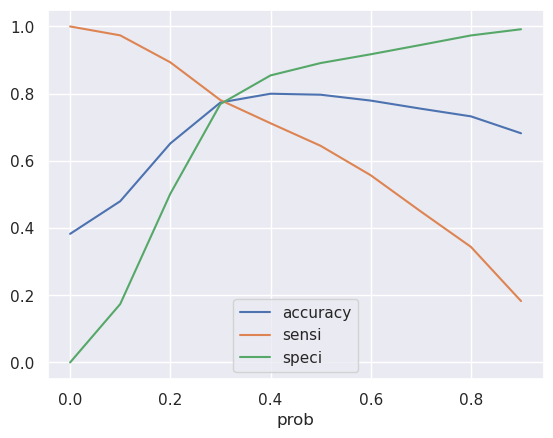

In [436]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [437]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.3 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           1       0.135  7263           0      1      1      0      0   
1           0       0.243  6468           0      1      1      1      0   
2           1       0.235  7833           0      1      1      1      0   
3           0       0.823  4461           1      1      1      1      1   
4           0       0.214  8453           0      1      1      1      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      0      0      0      0      0      0                 0  
2      0      0      0      0      0      0                 0  
3      1      1      1      1      1      0                 1  
4      0      0      0      0      0      0                 0

In [438]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7736742424242424

In [439]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3510, 1053],
       [ 620, 2209]])

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

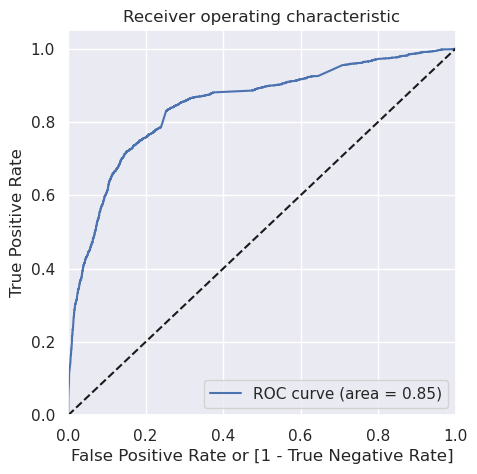

In [440]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [441]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7858681602757432

0.6447507953340403

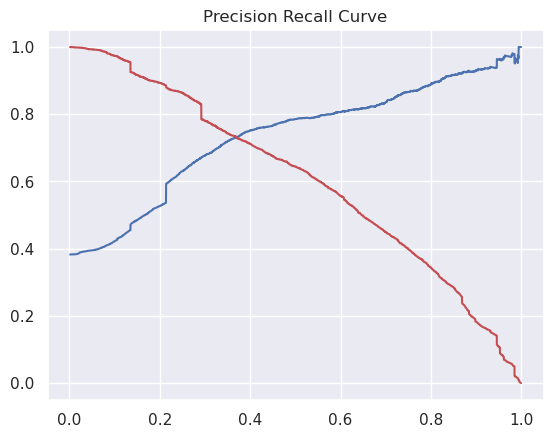

In [442]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [443]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [444]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

pg_view_pv  totalvisits  ttime_on_site  lead_source  last_activity  \
4269       2.106        1.667          0.967       -1.059          1.178   
2376      -1.272       -1.128         -0.885        1.904          1.178   
7766       1.543        0.619         -0.777       -0.401          1.451   
9199      -1.272       -1.128         -0.885        0.587          0.359   
4359      -1.272       -1.128         -0.885        1.904         -0.734   

      curr_occupation  city  do_not_email_1  \
4269           -0.134     0           0.000   
2376           -0.134     0           0.000   
7766            2.694     4           0.000   
9199           -0.134     0           0.000   
4359           -0.134     4           0.000   

      lead_origin_Landing Page Submission  lead_origin_Lead Add Form  
4269                                0.000                      0.000  
2376                                0.000                      1.000  
7766                                0.000                      0.000  
9199                                0.000                      0.000  
4359                                0.000                      1.000

In [445]:
cutoff = 0.3
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7381
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3453.8
Date:                Thu, 17 Oct 2024   Deviance:                       6907.5
Time:                        01:39:40   Pearson chi2:                 8.52e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3272
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.6907      0.052    -13.317      0.000      -0.792      -0.589
pg_view_pv                             -0.2625      0.048     -5.470      0.000      -0.357      -0.168
totalvisits                             0.1730      0.043      4.031      0.000       0.089       0.257
ttime_on_site                           1.0535      0.034     31.337      0.000       0.988       1.119
lead_source                             0.1087      0.042      2.604      0.009       0.027       0.191
last_activity                           0.5069      0.031     16.112      0.000       0.445       0.569
curr_occupation                         0.4671      0.037     12.626      0.000       0.395       0.540
city                                    0.0718      0.024      3.025      0.002       0.025       0.118
do_not_email_1                         -1.5149      0.147    -10.321      0.000      -1.803      -1.227
lead_origin_Landing Page Submission    -0.1646      0.083     -1.995      0.046      -0.326      -0.003
lead_origin_Lead Add Form               3.6020      0.190     18.977      0.000       3.230       3.974
=======================================================================================================
"""


VIF Score:


Features   VIF
0                           pg_view_pv 2.700
1                          totalvisits 2.530
3                          lead_source 1.980
8  lead_origin_Landing Page Submission 1.920
9            lead_origin_Lead Add Form 1.820
6                                 city 1.370
2                        ttime_on_site 1.270
7                       do_not_email_1 1.110
5                      curr_occupation 1.040
4                        last_activity 1.030

In [446]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[850, 266],
       [161, 571]])


Accuracy Score: 0.7689393939393939



## -----------------------------------------------------

In [447]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## -----------------------------------------------------

## Approach - 03

### Data Encoding

#### Dummy Encoding

In [243]:
#  we perform dummy encoding

new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns, drop_first=True, dtype=float)
new_ls_df.head(1)

lead_number  converted  totalvisits  ttime_on_site  pg_view_pv  \
0       660737          0        0.000          0.000       0.000   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                0.000                      0.000   

   lead_origin_Lead Import  lead_origin_Quick Add Form  \
0                    0.000                       0.000   

   lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
0                       0.000                 0.000               0.000   

   lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
0                  0.000               0.000                   1.000   

   lead_source_Organic Search  lead_source_Pay per Click Ads  \
0                       0.000                          0.000   

   lead_source_Press_Release  lead_source_Reference  \
0                      0.000                  0.000   

   lead_source_Referral Sites  lead_source_Social Media  lead_source_WeLearn  \
0                       0.000                     0.000                0.000   

   lead_source_Welingak Website  lead_source_bing  lead_source_blog  \
0                         0.000             0.000             0.000   

   lead_source_google  lead_source_testone  lead_source_welearnblog_Home  \
0               0.000                0.000                         0.000   

   lead_source_youtubechannel  do_not_email_1  \
0                       0.000           0.000   

   last_activity_Converted to Lead  last_activity_Email Bounced  \
0                            0.000                        0.000   

   last_activity_Email Link Clicked  last_activity_Email Marked Spam  \
0                             0.000                            0.000   

   last_activity_Email Opened  last_activity_Email Received  \
0                       0.000                         0.000   

   last_activity_Form Submitted on Website  \
0                                    0.000   

   last_activity_Had a Phone Conversation  \
0                                   0.000   

   last_activity_Olark Chat Conversation  \
0                                  0.000   

   last_activity_Page Visited on Website  \
0                                  1.000   

   last_activity_Resubscribed to emails  last_activity_SMS Sent  \
0                                 0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
0                      0.000                       0.000   

   last_activity_View in browser link Clicked  \
0                                       0.000   

   last_activity_Visited Booth in Tradeshow  country_Australia  \
0                                     0.000              0.000   

   country_Bahrain  country_Bangladesh  country_Belgium  country_Canada  \
0            0.000               0.000            0.000           0.000   

   country_China  country_Denmark  country_France  country_Germany  \
0          0.000            0.000           0.000            0.000   

   country_Ghana  country_Hong Kong  country_India  country_Indonesia  \
0          0.000              0.000          1.000              0.000   

   country_Italy  country_Kenya  country_Kuwait  country_Liberia  \
0          0.000          0.000           0.000            0.000   

   country_Malaysia  country_Netherlands  country_Nigeria  country_Oman  \
0             0.000                0.000            0.000         0.000   

   country_Philippines  country_Qatar  country_Russia  country_Saudi Arabia  \
0                0.000          0.000           0.000                 0.000   

   country_Singapore  country_South Africa  country_Sri Lanka  country_Sweden  \
0              0.000                 0.000              0.000           0.000   

   country_Switzerland  country_Tanzania  country_Uganda  \
0                0.000             0.000           0.000   

   country_United Arab Emirates  country_United Kingdom  \
0                         0.00

###  ----------------------------------------------------------------------

### Train and Test Split

In [244]:
X = new_ls_df.drop(['lead_number','converted'], axis=1)
y = new_ls_df['converted']

In [245]:
# Now we split the dataset into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

###  ----------------------------------------------------------------------

### Feature Scaling

In [246]:
new_ls_df.dtypes

lead_number                                         int64
converted                                           int64
totalvisits                                       float64
ttime_on_site                                     float64
pg_view_pv                                        float64
lead_origin_Landing Page Submission               float64
lead_origin_Lead Add Form                         float64
lead_origin_Lead Import                           float64
lead_origin_Quick Add Form                        float64
lead_source_Direct Traffic                        float64
lead_source_Facebook                              float64
lead_source_Google                                float64
lead_source_Live Chat                             float64
lead_source_NC_EDM                                float64
lead_source_Olark Chat                            float64
lead_source_Organic Search                        float64
lead_source_Pay per Click Ads                     float64
lead_source_Pr

In [247]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = list(set(list(X.columns)) - set(['totalvisits','ttime_on_site','pg_view_pv']))
to_scale

scaler = MinMaxScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head()

['lead_source_NC_EDM',
 'country_Sri Lanka',
 'last_activity_Email Marked Spam',
 'country_Indonesia',
 'last_activity_Olark Chat Conversation',
 'country_Uganda',
 'country_Switzerland',
 'curr_occupation_Working Professional',
 'country_South Africa',
 'lead_origin_Lead Add Form',
 'country_Australia',
 'lead_source_WeLearn',
 'last_activity_Resubscribed to emails',
 'last_activity_Email Link Clicked',
 'last_activity_Unsubscribed',
 'lead_source_Live Chat',
 'country_Germany',
 'country_Italy',
 'city_Tier II Cities',
 'lead_source_youtubechannel',
 'last_activity_Converted to Lead',
 'lead_source_Welingak Website',
 'lead_source_Social Media',
 'country_Nigeria',
 'country_Kenya',
 'country_United States',
 'lead_source_Google',
 'city_Other Cities of Maharashtra',
 'lead_source_Organic Search',
 'country_Oman',
 'reason_behind_course_Other',
 'lead_source_Reference',
 'country_France',
 'country_Belgium',
 'country_India',
 'country_Singapore',
 'curr_occupation_Housewife',
 'last

totalvisits  ttime_on_site  pg_view_pv  \
7263        0.000          0.000       0.000   
6468        2.000        138.000       2.000   
7833        2.000         79.000       2.000   
4461        4.000       1579.000       4.000   
8453        0.000          0.000       0.000   

      lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
7263                                0.000                      0.000   
6468                                1.000                      0.000   
7833                                1.000                      0.000   
4461                                1.000                      0.000   
8453                                0.000                      0.000   

      lead_origin_Lead Import  lead_origin_Quick Add Form  \
7263                    0.000                       0.000   
6468                    0.000                       0.000   
7833                    0.000                       0.000   
4461                    0.000                       0.000   
8453                    0.000                       0.000   

      lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
7263                       0.000                 0.000               0.000   
6468                       1.000                 0.000               0.000   
7833                       1.000                 0.000               0.000   
4461                       0.000                 0.000               1.000   
8453                       0.000                 0.000               0.000   

      lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
7263                  0.000               0.000                   1.000   
6468                  0.000               0.000                   0.000   
7833                  0.000               0.000                   0.000   
4461                  0.000               0.000                   0.000   
8453                  0.000               0.000                   1.000   

      lead_source_Organic Search  lead_source_Pay per Click Ads  \
7263                       0.000                          0.000   
6468                       0.000                          0.000   
7833                       0.000                          0.000   
4461                       0.000                          0.000   
8453                       0.000                          0.000   

      lead_source_Press_Release  lead_source_Reference  \
7263                      0.000                  0.000   
6468                      0.000                  0.000   
7833                      0.000                  0.000   
4461                      0.000                  0.000   
8453                      0.000                  0.000   

      lead_source_Referral Sites  lead_source_Social Media  \
7263                       0.000                     0.000   
6468                       0.000                     0.000   
7833                       0.000                     0.000   
4461                       0.000                     0.000   
8453                       0.000                     0.000   

      lead_source_WeLearn  lead_source_Welingak Website  lead_source_bing  \
7263                0.000                         0.000             0.000   
6468                0.000                         0.000             0.000   
7833                0.000                         0.000             0.000   
4461                0.000                         0.000             0.000   
8453                0.000                         0.000             0.000   

      lead_source_blog  lead_source_google  lead_source_testone  \
7263             0.000               0.000                0.000   
6468             0.000               0.000                0.000   
7833             0.000               0.000                0.000   
4461             0.000               0.000                0.000   
8453             0.000               0.000                0.000   

      

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [248]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [249]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7302
Model Family:                Binomial   Df Model:                           89
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3036.0
Date:                Thu, 17 Oct 2024   Deviance:                       6071.9
Time:                        01:33:53   Pearson chi2:                 1.04e+04
No. Iterations:                    23   Pseudo R-squ. (CS):             0.3991
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             22.3659   3.53e+04      0.001      0.999   -6.92e+04    6.93e+04
totalvisits                                        0.1292      0.017      7.397      0.000       0.095       0.163
ttime_on_site                                      0.0020   6.84e-05     29.179      0.000       0.002       0.002
pg_view_pv                                        -0.1752      0.032     -5.532      0.000      -0.237      -0.113
lead_origin_Landing Page Submission               -0.2082      0.103     -2.025      0.043      -0.410      -0.007
lead_origin_Lead Add Form                          3.1277      0.523      5.984      0.000       2.103       4.152
lead_origin_Lead Import                            0.3092      2.075      0.149      0.882      -3.758       4.377
lead_origin_Quick Add Form                        24.1343   1.31e+05      0.000      1.000   -2.57e+05    2.57e+05
lead_source_Direct Traffic                         0.3833      1.356      0.283      0.777      -2.274       3.041
lead_source_Facebook                              -0.0918      2.479     -0.037      0.970      -4.950       4.767
lead_source_Google                                 0.6405      1.352      0.474      0.636      -2.009       3.290
lead_source_Live Chat                             22.9665   9.26e+04      0.000      1.000   -1.82e+05    1.82e+05
lead_source_NC_EDM                                25.0370   1.31e+05      0.000      1.000   -2.57e+05    2.57e+05
lead_source_Olark Chat                             1.5496      1.358      1.141      0.254      -1.111       4.211
lead_source_Organic Search                         0.4695      1.357      0.346      0.729      -2.190       3.130
lead_source_Pay per Click Ads                    -22.0185   1.31e+05     -0.000      1.000   -2.57e+05    2.57e+05
lead_source_Press_Release                        -21.5471   8.12e+04     -0.000      1.000   -1.59e+05    1.59e+05
lead_source_Reference                              0.8730      1.263      0.691      0.489      -1.603       3.349
lead_source_Referral Sites                         0.3007      1.383      0.217      0.828      -2.410       3.012
lead_source_Social Media                           2.9069      1.981      1.467      0.142      -0.976       6.789
lead_source_WeLearn                               24.9555   1.31e+05      0.000      1.000   -2.57e+05    2.57e+05
lead_source_Welingak Website                       3.1047      1.446      2.147      0.032       0.270       5.939
lead_source_bing                                   1.3628      1.866      0.731      0.465      -2.293       5.019
lead_source_blog                                 -22.8067   1.31e+05     -0.000      1.000   

##### RFE - Recursive Feature Elimination

In [250]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('totalvisits', False, 49),
 ('ttime_on_site', False, 66),
 ('pg_view_pv', False, 51),
 ('lead_origin_Landing Page Submission', False, 47),
 ('lead_origin_Lead Add Form', True, 1),
 ('lead_origin_Lead Import', False, 26),
 ('lead_origin_Quick Add Form', False, 71),
 ('lead_source_Direct Traffic', False, 27),
 ('lead_source_Facebook', False, 2),
 ('lead_source_Google', False, 60),
 ('lead_source_Live Chat', False, 54),
 ('lead_source_NC_EDM', False, 7),
 ('lead_source_Olark Chat', False, 50),
 ('lead_source_Organic Search', False, 48),
 ('lead_source_Pay per Click Ads', False, 28),
 ('lead_source_Press_Release', False, 58),
 ('lead_source_Reference', False, 24),
 ('lead_source_Referral Sites', False, 40),
 ('lead_source_Social Media', False, 13),
 ('lead_source_WeLearn', False, 6),
 ('lead_source_Welingak Website', True, 1),
 ('lead_source_bing', False, 69),
 ('lead_source_blog', False, 39),
 ('lead_source_google', False, 3),
 ('lead_source_testone', False, 80),
 ('lead_source_welearnb

In [251]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['totalvisits', 'ttime_on_site', 'pg_view_pv',
       'lead_origin_Landing Page Submission', 'lead_origin_Lead Import',
       'lead_origin_Quick Add Form', 'lead_source_Direct Traffic',
       'lead_source_Facebook', 'lead_source_Google', 'lead_source_Live Chat',
       'lead_source_NC_EDM', 'lead_source_Olark Chat',
       'lead_source_Organic Search', 'lead_source_Pay per Click Ads',
       'lead_source_Press_Release', 'lead_source_Reference',
       'lead_source_Referral Sites', 'lead_source_Social Media',
       'lead_source_WeLearn', 'lead_source_bing', 'lead_source_blog',
       'lead_source_google', 'lead_source_testone',
       'lead_source_welearnblog_Home', 'lead_source_youtubechannel',
       'last_activity_Email Bounced', 'last_activity_Email Link Clicked',
       'last_activity_Email Opened', 'last_activity_Email Received',
       'last_activity_Form Submitted on Website',
       'last_activity_Page Visited on Website',
       'last_activity_Resubscribed to emails',

##### Model 2

In [252]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7376
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3669.8
Date:                Thu, 17 Oct 2024   Deviance:                       7339.6
Time:                        01:33:59   Pearson chi2:                 8.85e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.2867
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.0289      0.549      0.053      0.958      -1.048       1.105
lead_origin_Lead Add Form                  2.6537      0.170     15.583      0.000       2.320       2.987
lead_source_Welingak Website               2.0134      0.738      2.728      0.006       0.567       3.460
do_not_email_1                            -1.6611      0.147    -11.296      0.000      -1.949      -1.373
last_activity_Converted to Lead           -1.3074      0.186     -7.022      0.000      -1.672      -0.942
last_activity_Email Marked Spam           26.2409   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
last_activity_Had a Phone Conversation     2.1922      0.595      3.687      0.000       1.027       3.358
last_activity_Olark Chat Conversation     -1.4622      0.139    -10.488      0.000      -1.735      -1.189
last_activity_SMS Sent                     1.2467      0.062     20.236      0.000       1.126       1.367
last_activity_Unsubscribed                 0.9972      0.412      2.423      0.015       0.191       1.804
country_Canada                           -23.1424   3.67e+04     -0.001      0.999   -7.19e+04    7.18e+04
country_Qatar                            -22.8804   2.54e+04     -0.001      0.999   -4.97e+04    4.97e+04
curr_occupation_Housewife                 22.7533   2.34e+04      0.001      0.999   -4.58e+04    4.58e+04
curr_occupation_Student                   -0.5805      0.581     -0.998      0.318      -1.720       0.559
curr_occupation_Unemployed                -1.0426      0.550     -1.894      0.058      -2.121       0.036
curr_occupation_Working Professional       1.9186      0.573      3.346      0.001       0.795       3.042
==========================================================================================================
"""


VIF Score:


Features   VIF
13              curr_occupation_Unemployed 1.920
7                   last_activity_SMS Sent 1.590
0                lead_origin_Lead Add Form 1.400
1             lead_source_Welingak Website 1.250
6    last_activity_Olark Chat Conversation 1.210
14    curr_occupation_Working Professional 1.200
2                           do_not_email_1 1.180
3          last_activity_Converted to Lead 1.100
8               last_activity_Unsubscribed 1.090
12                 curr_occupation_Student 1.020
5   last_activity_Had a Phone Conversation 1.010
9                           country_Canada 1.010
4          last_activity_Email Marked Spam 1.000
10                           country_Qatar 1.000
11               curr_occupation_Housewife 1.000

In [253]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:


Confusion Matrix:


array([[3762,  801],
       [ 985, 1844]])


Accuracy Score: 0.7583874458874459



##### Model 3

In [254]:
col = col.drop('curr_occupation_Housewife', 1)
col

Index(['lead_origin_Lead Add Form', 'lead_source_Welingak Website',
       'do_not_email_1', 'last_activity_Converted to Lead',
       'last_activity_Email Marked Spam',
       'last_activity_Had a Phone Conversation',
       'last_activity_Olark Chat Conversation', 'last_activity_SMS Sent',
       'last_activity_Unsubscribed', 'country_Canada', 'country_Qatar',
       'curr_occupation_Student', 'curr_occupation_Unemployed',
       'curr_occupation_Working Professional'],
      dtype='object')

In [255]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7377
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3672.7
Date:                Thu, 17 Oct 2024   Deviance:                       7345.4
Time:                        01:33:59   Pearson chi2:                 8.86e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.2861
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.6097      0.473      1.289      0.198      -0.318       1.537
lead_origin_Lead Add Form                  2.6564      0.170     15.604      0.000       2.323       2.990
lead_source_Welingak Website               2.0111      0.738      2.724      0.006       0.564       3.458
do_not_email_1                            -1.6635      0.147    -11.311      0.000      -1.952      -1.375
last_activity_Converted to Lead           -1.3077      0.186     -7.024      0.000      -1.673      -0.943
last_activity_Email Marked Spam           25.2430   4.82e+04      0.001      1.000   -9.44e+04    9.45e+04
last_activity_Had a Phone Conversation     2.1921      0.595      3.686      0.000       1.027       3.358
last_activity_Olark Chat Conversation     -1.4663      0.139    -10.513      0.000      -1.740      -1.193
last_activity_SMS Sent                     1.2465      0.062     20.232      0.000       1.126       1.367
last_activity_Unsubscribed                 0.9989      0.412      2.427      0.015       0.192       1.806
country_Canada                           -22.1425   2.22e+04     -0.001      0.999   -4.36e+04    4.36e+04
country_Qatar                            -21.8804   1.54e+04     -0.001      0.999   -3.02e+04    3.01e+04
curr_occupation_Student                   -1.1610      0.510     -2.276      0.023      -2.161      -0.161
curr_occupation_Unemployed                -1.6231      0.474     -3.422      0.001      -2.553      -0.693
curr_occupation_Working Professional       1.3381      0.501      2.672      0.008       0.356       2.320
==========================================================================================================
"""


VIF Score:


Features   VIF
12              curr_occupation_Unemployed 1.920
7                   last_activity_SMS Sent 1.590
0                lead_origin_Lead Add Form 1.390
1             lead_source_Welingak Website 1.250
6    last_activity_Olark Chat Conversation 1.210
13    curr_occupation_Working Professional 1.200
2                           do_not_email_1 1.180
3          last_activity_Converted to Lead 1.100
8               last_activity_Unsubscribed 1.090
11                 curr_occupation_Student 1.020
5   last_activity_Had a Phone Conversation 1.010
9                           country_Canada 1.010
4          last_activity_Email Marked Spam 1.000
10                           country_Qatar 1.000

In [256]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:


Confusion Matrix:


array([[3762,  801],
       [ 985, 1844]])


Accuracy Score: 0.7583874458874459



##### Model 4

In [257]:
col = col.drop('country_Canada', 1)
col

Index(['lead_origin_Lead Add Form', 'lead_source_Welingak Website',
       'do_not_email_1', 'last_activity_Converted to Lead',
       'last_activity_Email Marked Spam',
       'last_activity_Had a Phone Conversation',
       'last_activity_Olark Chat Conversation', 'last_activity_SMS Sent',
       'last_activity_Unsubscribed', 'country_Qatar',
       'curr_occupation_Student', 'curr_occupation_Unemployed',
       'curr_occupation_Working Professional'],
      dtype='object')

In [258]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3674.8
Date:                Thu, 17 Oct 2024   Deviance:                       7349.6
Time:                        01:33:59   Pearson chi2:                 8.87e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.2857
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.6096      0.473      1.288      0.198      -0.318       1.537
lead_origin_Lead Add Form                  2.6575      0.170     15.611      0.000       2.324       2.991
lead_source_Welingak Website               2.0110      0.738      2.724      0.006       0.564       3.458
do_not_email_1                            -1.6624      0.147    -11.303      0.000      -1.951      -1.374
last_activity_Converted to Lead           -1.3073      0.186     -7.021      0.000      -1.672      -0.942
last_activity_Email Marked Spam           25.2424   4.82e+04      0.001      1.000   -9.44e+04    9.45e+04
last_activity_Had a Phone Conversation     2.1925      0.595      3.687      0.000       1.027       3.358
last_activity_Olark Chat Conversation     -1.4659      0.139    -10.510      0.000      -1.739      -1.193
last_activity_SMS Sent                     1.2444      0.062     20.207      0.000       1.124       1.365
last_activity_Unsubscribed                 0.9748      0.410      2.377      0.017       0.171       1.779
country_Qatar                            -21.8789   1.54e+04     -0.001      0.999   -3.02e+04    3.01e+04
curr_occupation_Student                   -1.1604      0.510     -2.275      0.023      -2.160      -0.161
curr_occupation_Unemployed                -1.6235      0.474     -3.423      0.001      -2.553      -0.694
curr_occupation_Working Professional       1.3389      0.501      2.673      0.008       0.357       2.321
==========================================================================================================
"""


VIF Score:


Features   VIF
11              curr_occupation_Unemployed 1.920
7                   last_activity_SMS Sent 1.590
0                lead_origin_Lead Add Form 1.390
1             lead_source_Welingak Website 1.250
6    last_activity_Olark Chat Conversation 1.200
12    curr_occupation_Working Professional 1.200
2                           do_not_email_1 1.180
3          last_activity_Converted to Lead 1.100
8               last_activity_Unsubscribed 1.080
10                 curr_occupation_Student 1.020
5   last_activity_Had a Phone Conversation 1.010
4          last_activity_Email Marked Spam 1.000
9                            country_Qatar 1.000

In [259]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:


Confusion Matrix:


array([[3760,  803],
       [ 985, 1844]])


Accuracy Score: 0.7581168831168831



##### Model 5

In [260]:
col = col.drop('country_Qatar', 1)
col

Index(['lead_origin_Lead Add Form', 'lead_source_Welingak Website',
       'do_not_email_1', 'last_activity_Converted to Lead',
       'last_activity_Email Marked Spam',
       'last_activity_Had a Phone Conversation',
       'last_activity_Olark Chat Conversation', 'last_activity_SMS Sent',
       'last_activity_Unsubscribed', 'curr_occupation_Student',
       'curr_occupation_Unemployed', 'curr_occupation_Working Professional'],
      dtype='object')

In [261]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7379
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3678.5
Date:                Thu, 17 Oct 2024   Deviance:                       7357.0
Time:                        01:34:00   Pearson chi2:                 8.88e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.2850
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.6093      0.473      1.288      0.198      -0.318       1.537
lead_origin_Lead Add Form                  2.6601      0.170     15.626      0.000       2.326       2.994
lead_source_Welingak Website               2.0112      0.738      2.725      0.006       0.564       3.458
do_not_email_1                            -1.6640      0.147    -11.317      0.000      -1.952      -1.376
last_activity_Converted to Lead           -1.3051      0.186     -7.008      0.000      -1.670      -0.940
last_activity_Email Marked Spam           23.2466   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
last_activity_Had a Phone Conversation     2.1951      0.595      3.691      0.000       1.030       3.361
last_activity_Olark Chat Conversation     -1.4636      0.139    -10.493      0.000      -1.737      -1.190
last_activity_SMS Sent                     1.2438      0.062     20.210      0.000       1.123       1.364
last_activity_Unsubscribed                 0.9785      0.410      2.386      0.017       0.175       1.782
curr_occupation_Student                   -1.1603      0.510     -2.275      0.023      -2.160      -0.161
curr_occupation_Unemployed                -1.6257      0.474     -3.427      0.001      -2.555      -0.696
curr_occupation_Working Professional       1.3390      0.501      2.673      0.008       0.357       2.321
==========================================================================================================
"""


VIF Score:


Features   VIF
10              curr_occupation_Unemployed 1.920
7                   last_activity_SMS Sent 1.590
0                lead_origin_Lead Add Form 1.390
1             lead_source_Welingak Website 1.250
6    last_activity_Olark Chat Conversation 1.200
11    curr_occupation_Working Professional 1.200
2                           do_not_email_1 1.180
3          last_activity_Converted to Lead 1.100
8               last_activity_Unsubscribed 1.080
9                  curr_occupation_Student 1.020
5   last_activity_Had a Phone Conversation 1.010
4          last_activity_Email Marked Spam 1.000

In [262]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:


Confusion Matrix:


array([[3758,  805],
       [ 985, 1844]])


Accuracy Score: 0.7578463203463204



##### Model 6

In [263]:
col = col.drop('last_activity_Email Marked Spam', 1)
col

Index(['lead_origin_Lead Add Form', 'lead_source_Welingak Website',
       'do_not_email_1', 'last_activity_Converted to Lead',
       'last_activity_Had a Phone Conversation',
       'last_activity_Olark Chat Conversation', 'last_activity_SMS Sent',
       'last_activity_Unsubscribed', 'curr_occupation_Student',
       'curr_occupation_Unemployed', 'curr_occupation_Working Professional'],
      dtype='object')

In [264]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7380
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3681.2
Date:                Thu, 17 Oct 2024   Deviance:                       7362.5
Time:                        01:34:00   Pearson chi2:                 8.88e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2845
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.6087      0.473      1.287      0.198      -0.318       1.536
lead_origin_Lead Add Form                  2.6575      0.170     15.620      0.000       2.324       2.991
lead_source_Welingak Website               2.0104      0.738      2.724      0.006       0.564       3.457
do_not_email_1                            -1.6446      0.146    -11.255      0.000      -1.931      -1.358
last_activity_Converted to Lead           -1.3058      0.186     -7.013      0.000      -1.671      -0.941
last_activity_Had a Phone Conversation     2.1927      0.594      3.689      0.000       1.028       3.358
last_activity_Olark Chat Conversation     -1.4645      0.139    -10.500      0.000      -1.738      -1.191
last_activity_SMS Sent                     1.2420      0.062     20.189      0.000       1.121       1.363
last_activity_Unsubscribed                 0.9599      0.410      2.343      0.019       0.157       1.763
curr_occupation_Student                   -1.1600      0.510     -2.275      0.023      -2.159      -0.161
curr_occupation_Unemployed                -1.6243      0.474     -3.425      0.001      -2.554      -0.695
curr_occupation_Working Professional       1.3390      0.501      2.674      0.007       0.358       2.320
==========================================================================================================
"""


VIF Score:


Features   VIF
9               curr_occupation_Unemployed 1.920
6                   last_activity_SMS Sent 1.590
0                lead_origin_Lead Add Form 1.390
1             lead_source_Welingak Website 1.250
5    last_activity_Olark Chat Conversation 1.200
10    curr_occupation_Working Professional 1.200
2                           do_not_email_1 1.180
3          last_activity_Converted to Lead 1.100
7               last_activity_Unsubscribed 1.080
8                  curr_occupation_Student 1.020
4   last_activity_Had a Phone Conversation 1.010

In [265]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:


Confusion Matrix:


array([[3758,  805],
       [ 986, 1843]])


Accuracy Score: 0.757711038961039



####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [266]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           1       0.266  7263           0      1      1      1      0   
1           0       0.556  6468           1      1      1      1      1   
2           1       0.556  7833           1      1      1      1      1   
3           0       0.556  4461           1      1      1      1      1   
4           0       0.077  8453           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900  
0      0      0      0      0      0      0  
1      1      1      0      0      0      0  
2      1      1      0      0      0      0  
3      1      1      0      0      0      0  
4      0      0      0      0      0      0

In [267]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.383  1.000  0.000
0.100 0.100     0.544  0.966  0.282
0.200 0.200     0.560  0.952  0.317
0.300 0.300     0.753  0.661  0.811
0.400 0.400     0.758  0.654  0.823
0.500 0.500     0.758  0.651  0.824
0.600 0.600     0.736  0.340  0.981
0.700 0.700     0.731  0.323  0.984
0.800 0.800     0.728  0.313  0.985
0.900 0.900     0.688  0.194  0.994


<Axes: xlabel='prob'>

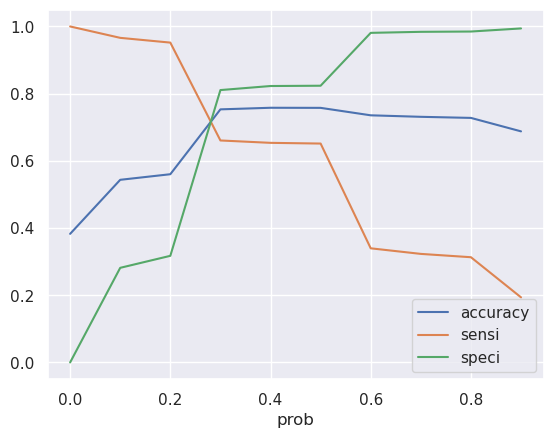

In [268]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [269]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.35 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           1       0.266  7263           0      1      1      1      0   
1           0       0.556  6468           1      1      1      1      1   
2           1       0.556  7833           1      1      1      1      1   
3           0       0.556  4461           1      1      1      1      1   
4           0       0.077  8453           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      1      1      0      0      0      0                 1  
2      1      1      0      0      0      0                 1  
3      1      1      0      0      0      0                 1  
4      0      0      0      0      0      0                 0

In [270]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7532467532467533

In [271]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3699,  864],
       [ 960, 1869]])

#### ROC Curve and Precision - Recall Curve

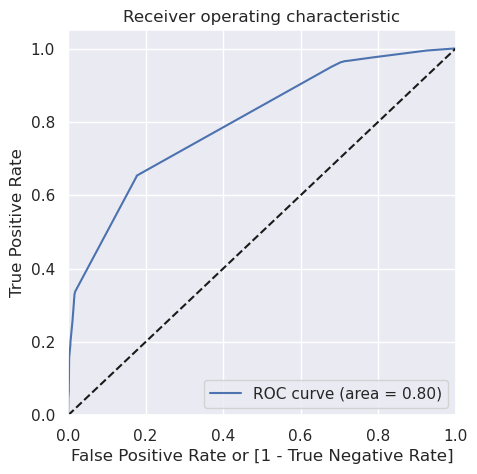

In [272]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [273]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.6959969788519638

0.6514669494521033

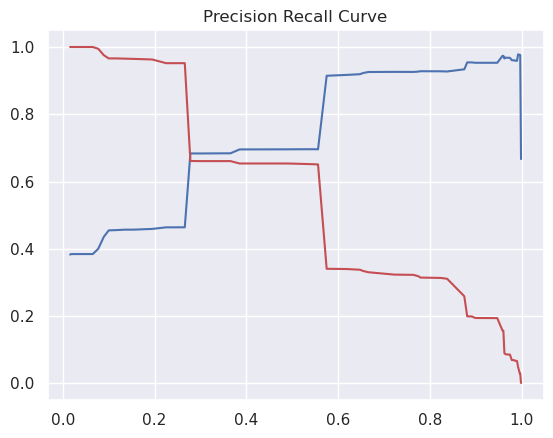

In [274]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [275]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [276]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

lead_origin_Lead Add Form  lead_source_Welingak Website  do_not_email_1  \
4269                      0.000                         0.000           0.000   
2376                      1.000                         0.000           0.000   
7766                      0.000                         0.000           0.000   
9199                      0.000                         0.000           0.000   
4359                      1.000                         0.000           0.000   

      last_activity_Converted to Lead  last_activity_Had a Phone Conversation  \
4269                            0.000                                   0.000   
2376                            0.000                                   0.000   
7766                            0.000                                   0.000   
9199                            0.000                                   0.000   
4359                            0.000                                   0.000   

      last_activity_Olark Chat Conversation  last_activity_SMS Sent  \
4269                                  0.000                   1.000   
2376                                  0.000                   1.000   
7766                                  0.000                   0.000   
9199                                  1.000                   0.000   
4359                                  0.000                   0.000   

      last_activity_Unsubscribed  curr_occupation_Student  \
4269                       0.000                    0.000   
2376                       0.000                    0.000   
7766                       0.000                    0.000   
9199                       0.000                    0.000   
4359                       0.000                    0.000   

      curr_occupation_Unemployed  curr_occupation_Working Professional  
4269                       1.000                                 0.000  
2376                       1.000                                 0.000  
7766                       0.000                                 1.000  
9199                       1.000                                 0.000  
4359                       1.000                                 0.000

In [277]:
cutoff = 0.3
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif


Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7380
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3681.2
Date:                Thu, 17 Oct 2024   Deviance:                       7362.5
Time:                        01:34:01   Pearson chi2:                 8.88e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2845
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.6087      0.473      1.287      0.198      -0.318       1.536
lead_origin_Lead Add Form                  2.6575      0.170     15.620      0.000       2.324       2.991
lead_source_Welingak Website               2.0104      0.738      2.724      0.006       0.564       3.457
do_not_email_1                            -1.6446      0.146    -11.255      0.000      -1.931      -1.358
last_activity_Converted to Lead           -1.3058      0.186     -7.013      0.000      -1.671      -0.941
last_activity_Had a Phone Conversation     2.1927      0.594      3.689      0.000       1.028       3.358
last_activity_Olark Chat Conversation     -1.4645      0.139    -10.500      0.000      -1.738      -1.191
last_activity_SMS Sent                     1.2420      0.062     20.189      0.000       1.121       1.363
last_activity_Unsubscribed                 0.9599      0.410      2.343      0.019       0.157       1.763
curr_occupation_Student                   -1.1600      0.510     -2.275      0.023      -2.159      -0.161
curr_occupation_Unemployed                -1.6243      0.474     -3.425      0.001      -2.554      -0.695
curr_occupation_Working Professional       1.3390      0.501      2.674      0.007       0.358       2.320
==========================================================================================================
"""


VIF Score:


Features   VIF
9               curr_occupation_Unemployed 1.900
0                lead_origin_Lead Add Form 1.580
6                   last_activity_SMS Sent 1.550
1             lead_source_Welingak Website 1.410
5    last_activity_Olark Chat Conversation 1.230
10    curr_occupation_Working Professional 1.220
2                           do_not_email_1 1.200
3          last_activity_Converted to Lead 1.100
7               last_activity_Unsubscribed 1.100
8                  curr_occupation_Student 1.050
4   last_activity_Had a Phone Conversation 1.010

In [278]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[917, 199],
       [265, 467]])


Accuracy Score: 0.7489177489177489



## ------------------------------------------------------

In [ ]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## ------------------------------------------------------

##  Approach - 04

In [44]:
# new_ls_df 
lead_score_df.isna().sum()

lead_number             0
lead_origin             0
lead_source             0
do_not_email            0
converted               0
totalvisits             0
ttime_on_site           0
pg_view_pv              0
last_activity           0
country                 0
curr_occupation         0
reason_behind_course    0
city                    0
avail_free_copy         0
dtype: int64

## ------------------------------------------------------